# ML final project - E-commerce sessions prediction

**Import libraries**

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

from numpy import interp
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings
warnings.filterwarnings('ignore')

**Plot & graphs functions**

In [7]:
# function to plot pie chart purchase distribution
def plot_pie(dtframe, col):
    yes_purchase = dtframe[col].sum()
    no_purchase = dtframe.shape[0]-yes_purchase
    # declaring data
    data = [yes_purchase, no_purchase]
    keys = ['purchase', 'no purchase']
    plt.figure(figsize=(6, 6))
    plt.pie(data, labels=keys, autopct='%.0f%%')
    # displaying chart
    plt.show()

# function to plot correlation heatmap
def plot_corr_heatmap(col,w,h):
    plt.figure(figsize=(w,h))
    heatmap = sns.heatmap(df[col].corr(),vmin=-1,vmax=1,annot=True,cmap='Blues');
    heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

# function to boxplot outliers
def plot_outliers(features, col):
    fig, ax = plt.subplots(3,2,figsize=(25,25))
    for i, j in zip(features,ax.flatten()):
        sns.boxplot(x=col, y=i,ax=j, data=df)

# function to plot distribution
def plot_distribution(features_lst):
    for feature in features_lst:
        sns.displot(df, x=feature, kind='kde', height=3, aspect=3)
        
# function to plot histogram
def plot_histogram(features_lst):
    for feature in features_lst:
        plt.hist(df[feature])

# function to plot scatterplot
def plot_scatterplot(dtframe, x_ax, y_ax):
    sns.scatterplot(data=dtframe, x=x_ax, y=y_ax)

# function to plot countplot with percentage
def plot_countplot_percentage(dtframe,x_param,hue_param,w,h,x_label,y_label,title,percentage):
    plt.figure(figsize=(w, h))
    ax = sns.countplot(x=x_param,hue=hue_param,data=dtframe, palette="Blues")
    ax.set(xlabel=x_label, ylabel='Count')
    plt.title(title,fontsize=16)
    if percentage==True:
        all_heights = [[p.get_height() for p in bars] for bars in ax.containers]
        for bars in ax.containers:
            for i, p in enumerate(bars):
                total = sum(xgroup[i] for xgroup in all_heights)
                percentage = f'{(100 * p.get_height() / total) :.0f}%'
                ax.annotate(percentage, (p.get_x() + p.get_width() / 2, p.get_height()), size=11, ha='center', va='bottom')
    plt.grid()

# function to plot months by order
def plot_months_by_order(dtframe, col):
    plt.figure(figsize=(10,5))
    ax=sns.countplot(x='Month',data=df, order=m_date, palette='Blues')
    plt.title('Purchase per month', fontsize=16)
    plt.grid()
    
# function to plot all features importance
def plot_all_feature_importance(dtframe,cols, label):
    X = df[cols]
    y = df[label]
    importance = mutual_info_classif(X, y)
    plt.figure(figsize=(10,10))
    feature_importance = pd.Series(importance, X.columns[:len(X.columns)]).sort_values(ascending=True)
    feature_importance.plot(kind='barh')
    plt.grid()

# function to plot features importance for a specific prediction model
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette='Blues')
    #Add chart labels
    plt.title(model_type + ' feature importance')
    plt.xlabel('feature importance')
    plt.ylabel('feature names')


# function to plot confusion matrix for a specific prediction model
def plot_confusion_matrix(y, y_predict, title):
    plt.figure(figsize=(8,8))
    cm = confusion_matrix(y, y_predict)
    #print(cm)
    group_names = ['True Pos','False Pos','False Neg','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    ax.set_title(title);
    ax.set_xlabel('\nActual')
    ax.set_ylabel('Predicted ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['True','False'])
    ax.yaxis.set_ticklabels(['True','False'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
# function to plot ROC for Kfold validation
def plot_ROC_Kfold(X, y, clf, k):
    tprs = []
    aucs = []
    i = 1
    mean_fpr = np.linspace(0, 1, 100)
    kf = KFold(n_splits=k, shuffle=False)
    plt.figure(figsize=(10, 5))
    for train,test in kf.split(X):
        model = clf.fit(X[train], y[train])
        prediction = model.predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], prediction[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i+=1
    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr) 
    plt.plot(mean_fpr, mean_tpr, color='blue',label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr,tprs_lower,tprs_upper,color="grey",alpha=0.2,label=r"$\pm$ 1 std. dev.") 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for '+ str(clf) + ' model')
    plt.legend(loc="lower right")
    plt.show()

**Pre-processing functions**

In [8]:
# function to convert str to float and remove 'minutes' str
def remove_min_str_to_float(dtframe,col):
    removed = dtframe[col].astype('str').str.replace('minutes','').astype(float)
    return removed   
        
# function to remove outliers from upper q% quantile on selected
def remove_outliers(dtframe, features_lst,q):
    data_original=dtframe.copy()    
    for feature in features_lst:
        dtframe.drop(dtframe.loc[dtframe[feature] > dtframe[feature].quantile(q)].index, inplace=True)
    print ("I have {0} rows left after removing outliers from selected features.".format(dtframe.shape[0]))
    print ("They aaccount for","%.2f" %(((data_original.shape[0]-dtframe.shape[0])/data_original.shape[0])*100) , "%" ,
           "of the Train data. ", "\n")
    return dtframe

# function to fill nan values with 0 (page features only)
def nan_to_zero(dtframe,duration_col, num_col):
    dtframe.loc[((dtframe[duration_col].isna())&(dtframe[num_col]==0)),duration_col]=0
    dtframe.loc[((dtframe[num_col].isna())&(dtframe[duration_col]==0)),num_col]=0

# function to compute median value, while ignring NaNs
def compute_median(col):
    med = df[col].median()
    return med

# function to fill nan values
def fill_nans(dtframe,col,value):
    dtframe.loc[(dtframe[col].isna()),col]= value
    
# get average duration per page rather than total duration and number of pages
def avg_duration_per_page(dtframe,duration_col,num_col):
    avg = (dtframe[duration_col]/dtframe[num_col]).replace([np.inf, -np.inf], np.nan).fillna(0)
    return avg

# function to map values
def map_values(dtframe, col, map):
    mapped_col = dtframe[col].map(map)
    return mapped_col
   
# function to fill categorial nans
def fill_category_unknown(dtframe, col,name,new_val):
    dtframe.loc[dtframe[col]==name,col]= new_val
    dtframe.loc[dtframe[col].isna(),col]= new_val
    
# function to normalize feature
def normalize_feature(dtframe,col):
    feature = (dtframe[col] - dtframe[col].min())/(dtframe[col].max() - dtframe[col].min())
    return feature

# function to split to train and test by chosen features from df
def split_train_test_chosen_features(dtframe,features,label):
    X = dtframe[features]
    y = dtframe[label]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return  X_train, X_test, y_train, y_test  

#--------------------------------------------------------------------------------------------------------------------------
# support functions for test data preprocessing
def process_durations(dtframe,admin_col,info_col,product_col,
                      admin_col_num,info_col_num,product_col_num,
                      admin_duration_med,product_duration_med,info_duration_med,
                      num_admin_med,num_product_med,num_info_med):
    # change type and extract minutes
    dtframe[info_col] = remove_min_str_to_float(dtframe,info_col)
    dtframe[product_col] = remove_min_str_to_float(dtframe,product_col)
    # fill nan based on 0 duration and number of pages
    nan_to_zero(dtframe,admin_col,admin_col_num)
    nan_to_zero(dtframe,info_col,info_col_num)
    nan_to_zero(dtframe,product_col,product_col_num)
    # fill nan values in page deatures with median 
    fill_nans(dtframe,admin_col,admin_duration_med)
    fill_nans(dtframe,product_col,product_duration_med)
    fill_nans(dtframe,info_col,info_duration_med)
    # fill nan values in number of pages with median 
    fill_nans(dtframe,admin_col_num,num_admin_med)
    fill_nans(dtframe,product_col_num,num_product_med)
    fill_nans(dtframe,info_col_num,num_info_med)
    # calculate average per page
    dtframe['avg_admin_page_duration']= avg_duration_per_page(dtframe,admin_col,admin_col_num)
    dtframe['avg_info_page_duration']=avg_duration_per_page(dtframe,info_col,info_col_num) 
    dtframe['avg_product_page_duration']=avg_duration_per_page(dtframe,product_col,product_col_num)

def process_weekend(dtframe,col,value):
    dtframe['weekend_encoded']=dtframe[col]*1
    fill_nans(dtframe,'weekend_encoded',value)
    
def process_month_key(dtframe, col, month1, month2,d_map):
    dtframe.loc[(dtframe[col].isna()),col]= np.random.choice([month1,month2], size=None, replace=True, p=[0.5,0.5])
    dtframe['month_key'] = map_values(dtframe, col, d_map)

def process_browser_device(dtframe, browser, browser_map, device, med, device_map):
    dtframe['browser_name'] = dtframe[browser].str.split('_').str[0]
    fill_category_unknown(dtframe,'browser_name','browser','unknown')
    dtframe['browser_encoded'] = map_values(dtframe,'browser_name', browser_map)
    fill_nans(dtframe,device,med)
    dtframe['device_encoded'] = map_values(dtframe,device,device_map)
    dtframe['browser_device'] = dtframe['browser_encoded']*dtframe['device_encoded']
    dtframe['browser_device_normalized'] = normalize_feature(dtframe,'browser_device')

def process_user_type(dtframe,col):
    fill_category_unknown(dtframe,col,'Other','other')
    
def process_A_num(dtframe, col):
    dtframe['A_num'] = (dtframe[col].str.split('_').str[1]).astype('float')
    # filling nan values with the most common values according to their appearance
    dtframe.loc[(dtframe['A_num'].isna()),'A_num']= np.random.choice([2,1,3], size=None, replace=True, p=[0.435,0.3,0.265])

def process_b_normalized(dtframe, col, med):
    fill_nans(dtframe,col,med)
    dtframe['B_normalized'] = normalize_feature(dtframe,col)
    
def process_c_encoded(dtframe, col, log_map):
    dtframe['C_encoded'] = map_values(dtframe,col,log_map)
    dtframe.loc[(dtframe['C_encoded'].isna()),'C_encoded']= np.random.choice([0,1], size=None, replace=True, p=[0.50,0.5])

# final function to prep-process the data set
def preprocessing(dtframe):
    admin_duration_med = compute_median('admin_page_duration')
    product_duration_med = compute_median('product_page_duration')
    info_duration_med = compute_median('info_page_duration')
    num_admin_med = compute_median('num_of_admin_pages')
    num_product_med = compute_median('num_of_product_pages')
    num_info_med = compute_median('num_of_info_pages')
    
    #'avg_admin_page_duration','avg_info_page_duration','avg_product_page_duration'
    process_durations(dtframe,'admin_page_duration','info_page_duration','product_page_duration',
                      'num_of_admin_pages','num_of_info_pages','num_of_product_pages',
                      admin_duration_med,product_duration_med,info_duration_med,
                      num_admin_med,num_product_med,num_info_med)
    
    #'ExitRates'
    exit_med = compute_median('ExitRates')
    fill_nans(dtframe,'ExitRates',exit_med)
    
    # 'PageValues'
    page_values_med = compute_median('PageValues')
    fill_nans(dtframe,'PageValues',page_values_med)
    
    # 'weekend_encoded'
    process_weekend(dtframe,'Weekend',0)    
    
    # 'month_key'
    m_date = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'June':6,
              'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
    process_month_key(dtframe,'Month','May','Nov',m_date)
    
    # 'browser_device_normalized'
    m_browser_num = {'unknown':0, 'edge':1, 'safari':2, 'chrome':3}
    device_med = compute_median('device')
    m_device_num = {7.0:1,5.0:2,6.0:3,8.0:4,4.0:5,3.0:6,1.0:7,2.0:8}
    process_browser_device(dtframe,'internet_browser',m_browser_num,'device',device_med,m_device_num)
    
    # 'Returning_Visitor'
    process_user_type(dtframe,'user_type')
    dtframe[['New_Visitor','Returning_Visitor','other']] = pd.get_dummies(dtframe['user_type'])
    
    # 'Region'
    fill_nans(dtframe,'Region',1)
    
    # 'A_num'
    process_A_num(dtframe, 'A')    
    
    # 'B_normalized'
    B_med = compute_median('B')
    process_b_normalized(dtframe,'B',B_med)
    
    # 'C_encoded'
    http_err = {'log_100':0, 'log200':0, 'log202':0, 
            'log400':1, 'log404':1, 'log8080':1}
    process_c_encoded(dtframe,'C',http_err)
    return dtframe

**prediction models functions**

In [9]:
# functions to find best parameters and return the chosen parameters + train accuracy score
def find_best_parameters(model, params_dict, X, y):
    gscv = GridSearchCV(model, params_dict, cv=2, scoring = 'roc_auc')
    gscv.fit(X, y)
    chosen_params = gscv.best_params_
    best_score = gscv.best_score_
    return chosen_params, best_score

# functions to fit & predict LR model and return the predicted label + test accuracy score
def logistic_regression_model(best_params, X, y, X_test, y_test):
    lr = LogisticRegression(**best_params).fit(X, y)
    pred = lr.predict(X_test)
    test_acc_score = accuracy_score(y_test, pred)
    return lr, pred, test_acc_score

# functions to fit & predict NB model and return the train + test accuracy score
def gaussian_naive_bayes_model(X, y, X_test, y_test):
    nb = GaussianNB().fit(X, y)
    pred_train = nb.predict(X)
    pred_test = nb.predict(X_test)
    train_acc_score = accuracy_score(y_train, pred_train)
    test_acc_score = accuracy_score(y_test, pred_test)
    return train_acc_score, test_acc_score

# functions to fit & predict KNN model and return the train + test accuracy score
def knn_model(best_params,X, y,X_test, y_test):
    knn = KNeighborsClassifier(**best_params).fit(X, y)
    pred_train = knn.predict(X)
    pred_test = knn.predict(X_test)
    train_acc_score = accuracy_score(y_train, pred_train)
    test_acc_score = accuracy_score(y_test, pred_test)
    return train_acc_score, test_acc_score

# functions to fit & predict RF model and return the predicted label + test accuracy score
def random_forest_classifier_model(best_params, X, y, X_test, y_test):
    rf = RandomForestClassifier(**best_params).fit(X_train, y_train)
    pred = rf.predict(X_test)
    test_acc_score = accuracy_score(y_test, pred)
    return rf, pred, test_acc_score

# functions to fit & predict RF model and return the predicted label + test accuracy score
def MLP_classifier_model(best_params, X, y, X_test, y_test):
    mlp =  MLPClassifier(**best_params).fit(X, y)
    pred = mlp.predict(X_test)
    test_acc_score = accuracy_score(y_test, pred)
    return mlp, pred, test_acc_score

# functions to calculate & return the difference in accuracy score
def calculate_difference_in_train_test_score(test_score,train_score):
    diff = round(abs((test_score/train_score)-1),2)
    return diff

# function to print model results
def print_model_results(model,best_params,best_score,test_acc_score,diff,params):
    if params==True:
        print(f'Best hyperparameters for {model} model are: {best_params}\n')
    print(f'Train best score is: {round(best_score,3)} and test accuracy score is: {round(test_acc_score,3)}\n')
    print(f'The difference between the train and test score is: {diff*100}%.\n')
    print(f'Risk of overfitting? {diff>0.02}')

**Loading the data-set**

In [10]:
df = pd.read_csv("train.csv", index_col=0)

## 1. Data exploration & initial processing

### 1.1 Data Exploration

In [11]:
# check the size of the table
df.shape

(10479, 22)

The dataset has 10,479 entriess, each associated with a single session to which in the end a user decides wether to make a purchase ('purchase'=1) during the session or not ('purchase'=0). Each session 21 features collected by Google Analytics.

In [12]:
df.describe()

,num_of_admin_pages,admin_page_duration,num_of_info_pages,num_of_product_pages,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,device,Region,B,D,purchase
count,9874.000000,10066.000000,9792.000000,10076.000000,5726.000000,10457.000000,10453.000000,10452.000000,9983.000000,10156.000000,10460.000000,10456.000000,105.000000,10479.000000
mean,2.321957,80.462468,0.502655,31.870187,1302.457216,0.021854,0.042859,5.900387,0.061985,2.122981,3.155641,99.769628,4.060440,0.154690
std,3.335331,179.217548,1.265812,44.816259,2039.312905,0.048100,0.048297,18.727496,0.199429,0.906859,2.404672,10.050268,2.189818,0.361626
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,60.733919,-1.235571,0.000000
25%,0.000000,0.000000,0.000000,7.000000,221.000000,0.000000,0.014283,0.000000,0.000000,2.000000,1.000000,93.030568,3.141657,0.000000
50%,1.000000,8.000000,0.000000,18.000000,677.851191,0.002968,0.025161,0.000000,0.000000,2.000000,3.000000,99.787249,4.432221,0.000000
75%,4.000000,93.000000,0.000000,38.000000,1605.733333,0.016667,0.050000,0.000000,0.000000,3.000000,4.000000,106.506626,5.531061,0.000000
max,27.000000,3398.750000,24.000000,705.000000,47850.920680,0.200000,0.200000,361.763742,1.000000,8.000000,9.000000,141.735142,7.618254,1.000000


In [13]:
# check the types of each column
df.dtypes

num_of_admin_pages       float64
admin_page_duration      float64
num_of_info_pages        float64
info_page_duration        object
num_of_product_pages     float64
product_page_duration     object
total_duration           float64
BounceRates              float64
ExitRates                float64
PageValues               float64
closeness_to_holiday     float64
Month                     object
device                   float64
internet_browser          object
Region                   float64
user_type                 object
Weekend                   object
A                         object
B                        float64
C                         object
D                        float64
purchase                   int64
dtype: object

The data types of some of the features ('info page duration', 'product page duration') do not seem to match their actual type (according to feature's meaning). I will transform them from object to float.

In [14]:
df['info_page_duration'] = remove_min_str_to_float(df,'info_page_duration')
df['product_page_duration'] =  remove_min_str_to_float(df,'product_page_duration')

In [15]:
# NaN values
df.isna().sum()

num_of_admin_pages         605
admin_page_duration        413
num_of_info_pages          687
info_page_duration         317
num_of_product_pages       403
product_page_duration      621
total_duration            4753
BounceRates                 22
ExitRates                   26
PageValues                  27
closeness_to_holiday       496
Month                       25
device                     323
internet_browser           563
Region                      19
user_type                   23
Weekend                     23
A                          706
B                           23
C                           23
D                        10374
purchase                     0
dtype: int64

'D' and 'total duration' columns seem to have the majority of missing values, which raise a question mark regarding their importance or ability to contribute to the prediction models (to be explored further). For the other features I will fill the nan values according to their behaviour, distribution and other features that might be related.

### 1.2 Features Distribution

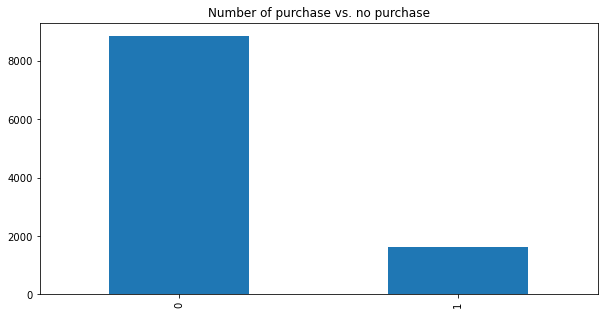

In [16]:
ax = df['purchase'].value_counts().plot(kind='bar',figsize=(10,5),title="Number of purchase vs. no purchase")

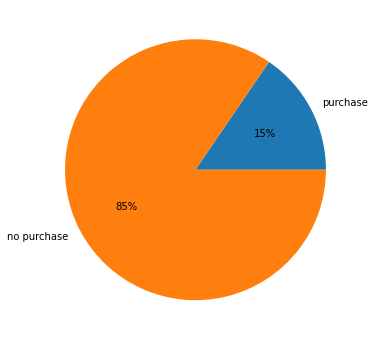

In [17]:
plot_pie(df, 'purchase')

The dataset shows that out of all users sessions, only 15% end up making a purchase on the website. The data is not balanced in terms of the label represntation and thus I will treat this later by splitting the data before training the models.

In [18]:
compare = df.groupby('purchase')[df.columns].median()
compare

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,closeness_to_holiday,device,Region,B,D,purchase
purchase,,,,,,,,,,,,,,,,
0,0.0,0.000000,0.0,0.0,16.0,506.183333,583.125000,0.004,0.028571,0.000000,0.0,2.0,3.0,99.823757,4.744755,0.0
1,2.0,55.333333,0.0,0.0,29.0,1110.866667,1217.703203,0.000,0.016000,16.247622,0.0,2.0,3.0,99.590502,0.167156,1.0


Generally, it seems that users who make purchase have a longer duration and more number of pages that they visit during a session, highr page values but lower exit rates are lower. Interesting to add is that the common device seems to be 2. Column D affects in a way that users who don't make a purchase have higher values.

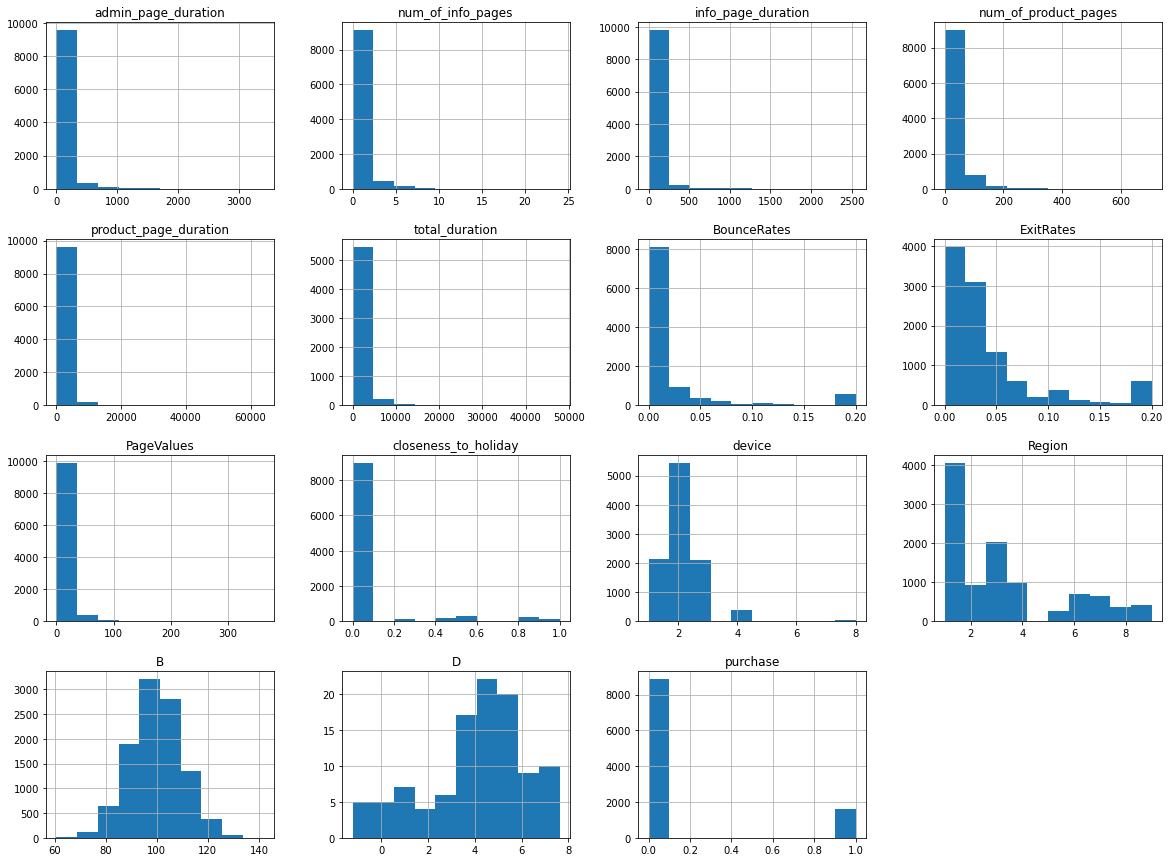

In [19]:
df.iloc[:,1:].hist(figsize=(20,15))
plt.show()

**Distributions:**
The number of pages and durations per each page type are distributed in a similar way to Poisson distribution (which matches the fact that these are time waiting measures). Device, 'B', 'D' seem to have Normal/ Gaussian distribution. <br>
The data is not normzlied (seen from the distributions and column types), which can be problematic if we measure two features in different ways (for example duration in minutes and total number of pages). One cannot properly compare between them, netiher measure the impact of each one of them on the model. In order to improve model accuracy, I will normalize the features in several ways (average, 0-1 etc.)

**Outlier removal:** In terms of outliers removal one can see that we have few features where the graphs are right-skewed or not evenly distributed (Gaussian). I will carefuly remove the outliers when exploring the features separately. 

**Categorial features:** 
will be treated either by transforming them to dummy variables (one-hat encoding) or by setting values that resemble their behaviour or importance in terms of frequency (for example 0,1,2). 


### 1.3 Correlation Heatmap

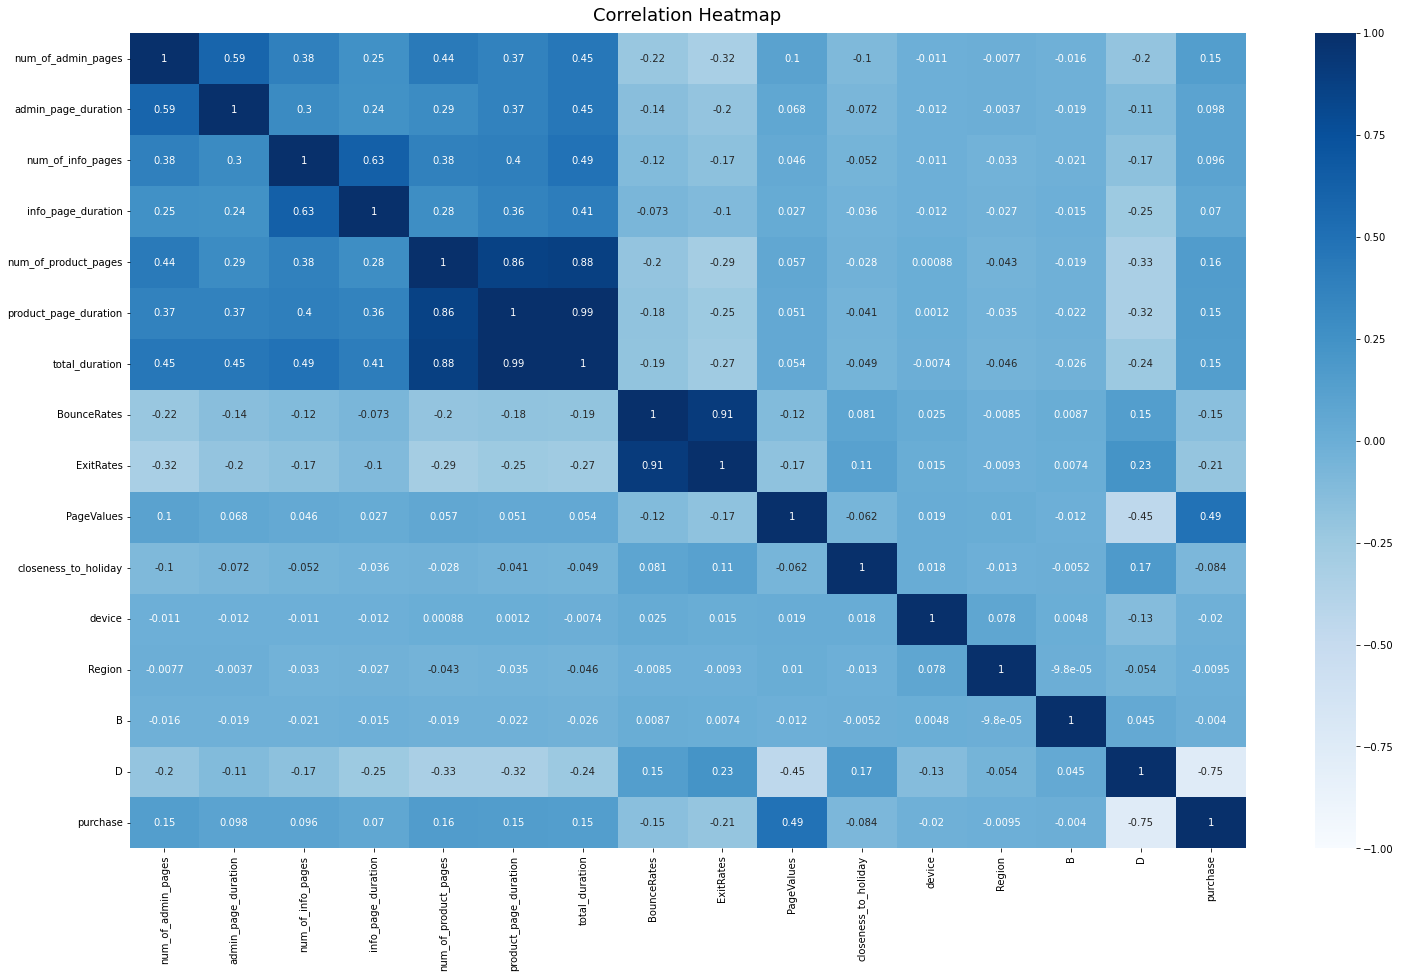

In [20]:
plot_corr_heatmap(df.columns, 25, 15)

**Main takeouts:**
1. The map shows the features that are highly correlated with the label (page values, D and exit rates to some extenet), and I will condier this when performing the feature selection.
2. There is a high correlation among all the different page durations and numbers (especially between total duration and product page duration, probably since users who make a purchase spend most of their time on product pages). Thus I will analyse these features as one unit.
3. There is a very high correlation between exit rates and bounce rates and one shall consider removing one of them.
4. There is a high correlation between page value and purchase to be investigated further.
5. There is a high negative correlation (75%) between 'D' column and final purchase (as well ad with pagevalues) to be investigated further (reminder: this column has  more than 90% values missing) and almost 50% (negative) correlation with PageValues. Is is also neagitvely correlated with the different page durations and number. All this indicates that this column might be very insightful to the following analysis.


In the next session, I decided to dive more into the features, their behaviour and correlation with other features, while splitting them into subsets of features that seem to have something in common. I will explore them further and process them in a mixed process as I believe that one cannot be done completely separated from the other.

## 2. Pre-processing

### 2.1 Outlier Removal

The graphs above and below show that the durations and number of pages are not distributed normally, but have a right-tail with outliers. I chose conservative method which only removes the top 99% quantile and only for features I would like to explore further due to their realtion to the label.

In [21]:
features_outliers=df[['num_of_admin_pages','admin_page_duration','num_of_info_pages',
                      'info_page_duration','num_of_product_pages','product_page_duration']]

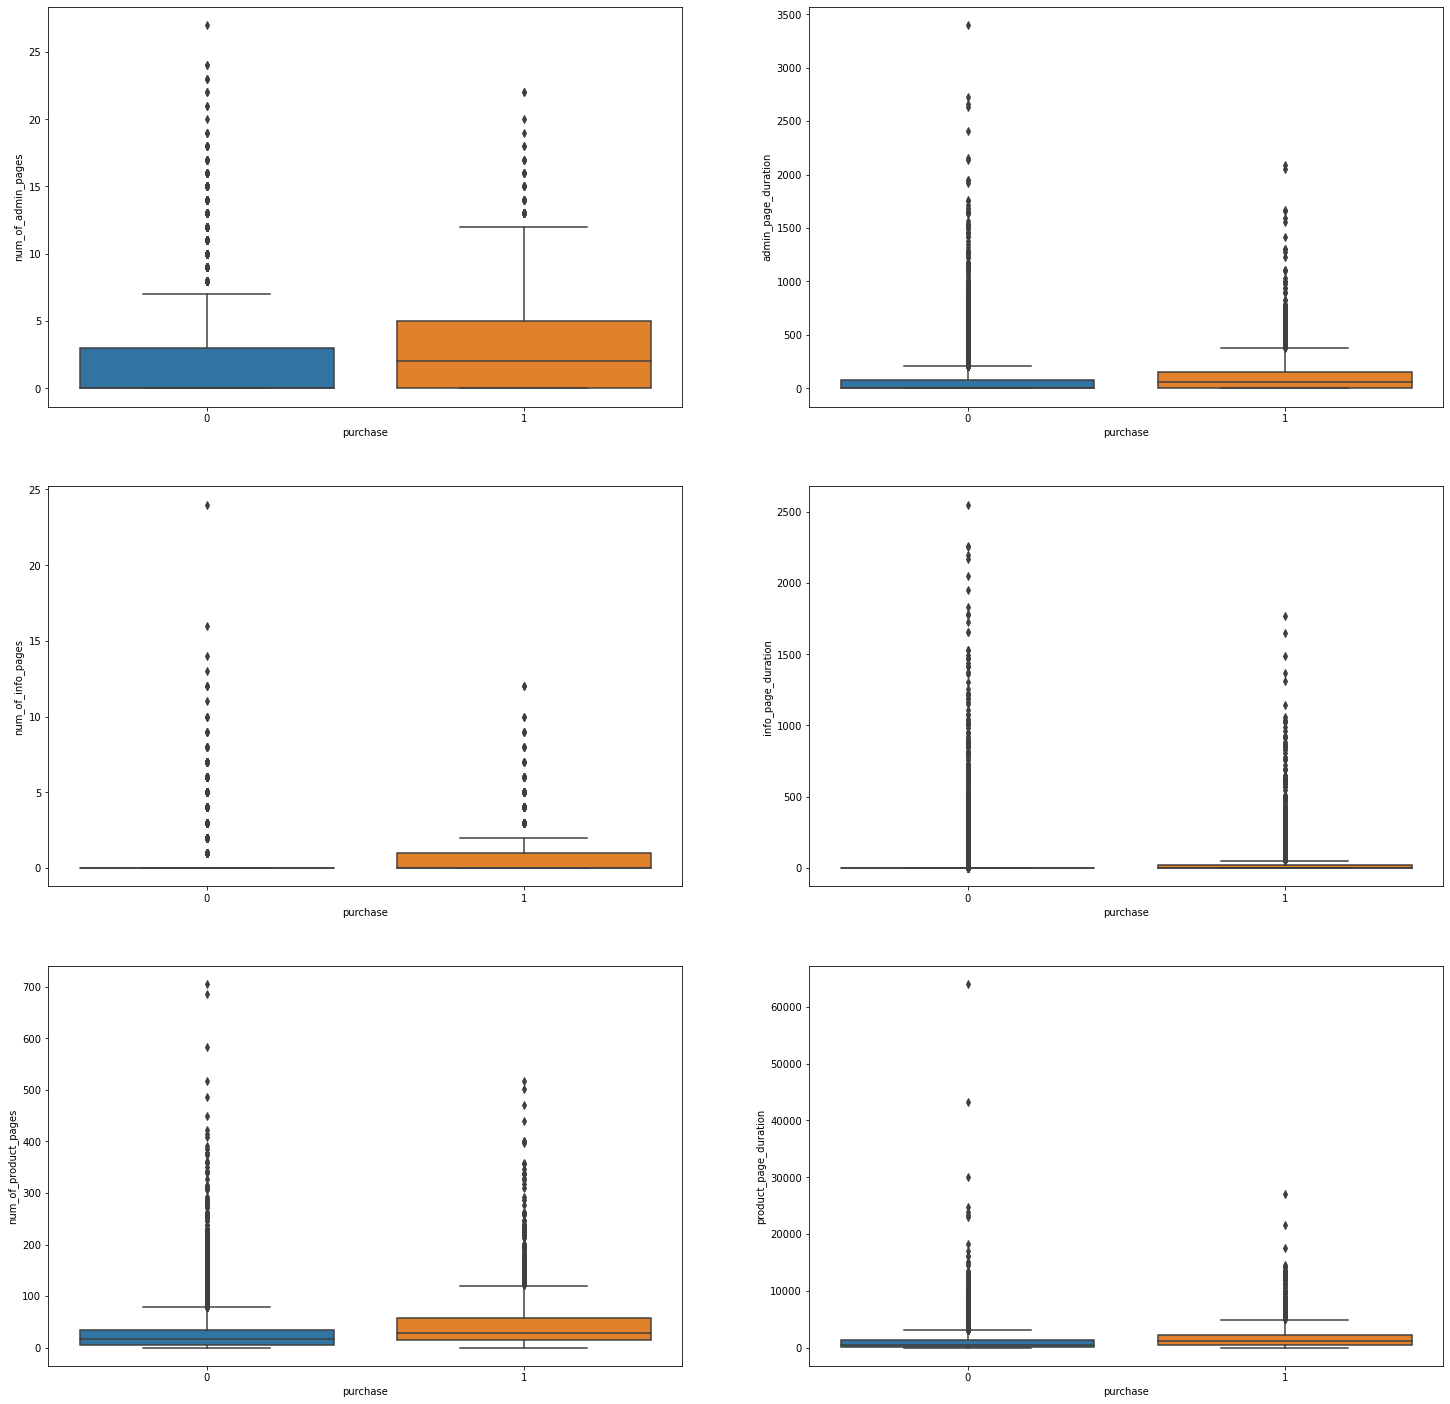

In [22]:
# plot outliers in chosen columns
plot_outliers(features_outliers, 'purchase')

In [23]:
#remove outliers above 99% quantile by features_outliers
remove_outliers(df,features_outliers,0.99)

I have 9939 rows left after removing outliers from selected features.
They aaccount for 5.15 % of the Train data.  



,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,...,device,internet_browser,Region,user_type,Weekend,A,B,C,D,purchase
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,1.0,0.000000,NaN,0.200000,0.200000,0.000000,...,1.0,safari_15,1.0,Returning_Visitor,False,c_1,118.880094,log202,NaN,0
1,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.200000,0.200000,0.000000,...,4.0,safari_14,9.0,Returning_Visitor,False,c_3,113.358423,log404,NaN,0
2,0.0,0.0,0.0,NaN,NaN,627.500000,627.500000,0.020000,0.050000,0.000000,...,3.0,browser_3_v17,1.0,Returning_Visitor,True,c_4,121.507695,log202,NaN,0
3,0.0,0.0,0.0,0.0,19.0,154.216667,154.216667,0.015789,0.024561,0.000000,...,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_3,93.747176,log_100,NaN,0
4,0.0,0.0,0.0,0.0,1.0,0.000000,NaN,0.200000,0.200000,0.000000,...,2.0,edge_96.0.1054.75,3.0,Returning_Visitor,False,c_3,99.545824,log202,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10474,3.0,145.0,0.0,0.0,53.0,1783.791667,1928.791667,0.007143,0.029031,12.241717,...,4.0,browser_6_v12,1.0,Returning_Visitor,True,c_1,79.548460,log400,NaN,0
10475,0.0,0.0,0.0,0.0,5.0,465.750000,NaN,0.000000,0.021333,0.000000,...,3.0,chrome_98.0.1,1.0,Returning_Visitor,True,c_8,99.457255,log202,NaN,0
10476,0.0,0.0,0.0,0.0,6.0,184.250000,NaN,0.083333,0.086667,0.000000,...,3.0,chrome_99.1.3,1.0,Returning_Visitor,True,c_13,94.417344,log8080,NaN,0


### 2.2 Exploring Duration & Number of Pages

In [24]:
page_features = df[['admin_page_duration','info_page_duration', 'product_page_duration',
                 'num_of_admin_pages','num_of_info_pages','num_of_product_pages',
                 'total_duration']]

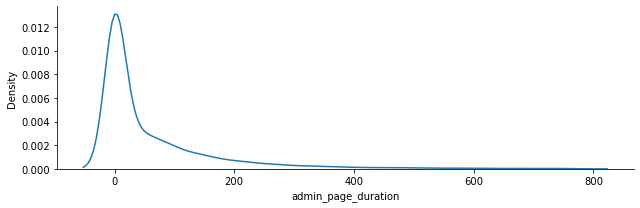

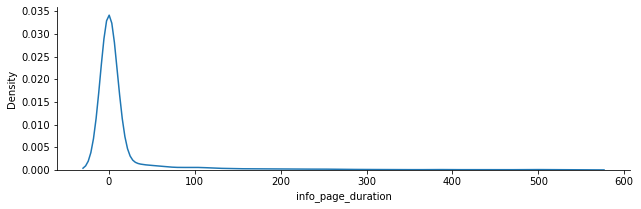

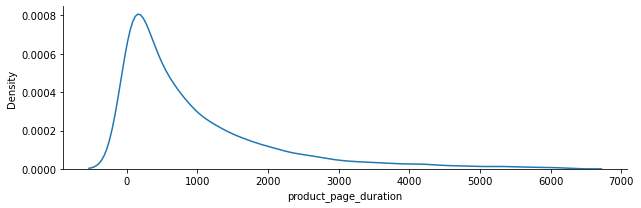

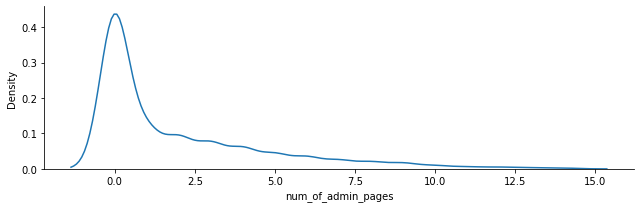

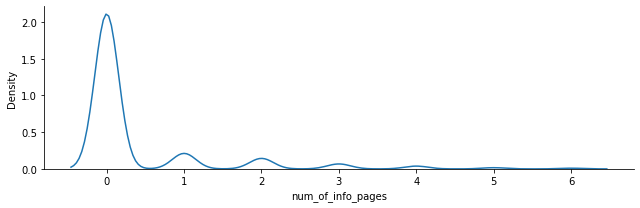

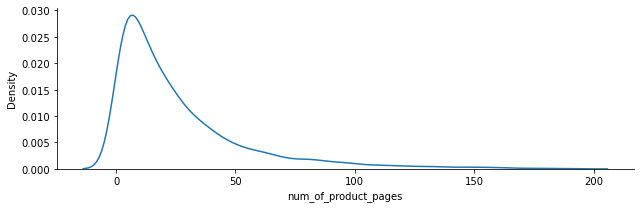

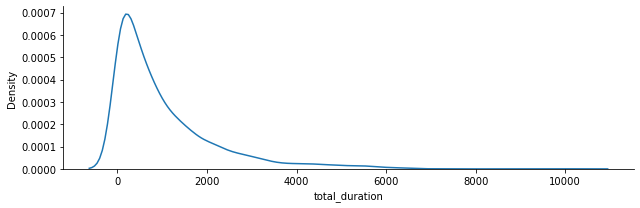

In [25]:
plot_distribution(page_features)

The distribution of the types of pages (duration and num of pages) is right-skewed. Thus, I chose to fill null values with medians rather than means. For nan durations with number of pages = 0 I chose to fill in 0 assumin that if there is no duration then there was no page visited, and vice versa. Missing values in total_duration will be calculated based on the sum of durations of all other pages, assuming that the total duration is time spent in admin, info and product pages.

In [26]:
# fill nan values with zero in case of no duration and vice versa
nan_to_zero(df,'admin_page_duration','num_of_admin_pages')
nan_to_zero(df,'info_page_duration','num_of_info_pages',)
nan_to_zero(df,'product_page_duration','num_of_product_pages')

In [27]:
# computing median values per duration per type, while ignoring NA's 
admin_duration_med = compute_median('admin_page_duration')
product_duration_med = compute_median('product_page_duration')
info_duration_med = compute_median('info_page_duration')

In [28]:
admin_duration_med, product_duration_med, info_duration_med

(0.0, 549.0833333, 0.0)

In [29]:
# computing median values per number of pages per type, while ignoring NA's 
num_admin_med = compute_median('num_of_admin_pages')
num_product_med = compute_median('num_of_product_pages')
num_info_med = compute_median('num_of_info_pages')

In [30]:
num_admin_med, num_product_med, num_info_med

(0.0, 17.0, 0.0)

The values of the medians hint that at least half of the users do not land in admin/info pages.

In [31]:
# fill nan values in page deatures with median 
fill_nans(df,'admin_page_duration',admin_duration_med)
fill_nans(df,'product_page_duration',product_duration_med)
fill_nans(df,'info_page_duration',info_duration_med)
# fill nan values in number of pages with median 
fill_nans(df,'num_of_admin_pages',num_admin_med)
fill_nans(df,'num_of_product_pages',num_product_med)
fill_nans(df,'num_of_info_pages',num_info_med)

In [32]:
# fill nan values in total duration based on the sum of all others
calculated_total_duration = df['admin_page_duration'] + df['product_page_duration'] + df['info_page_duration']
fill_nans(df,'total_duration',calculated_total_duration)

In [33]:
df['avg_admin_page_duration']= avg_duration_per_page(df,'admin_page_duration','num_of_admin_pages')
df['avg_info_page_duration']=avg_duration_per_page(df,'info_page_duration','num_of_info_pages') 
df['avg_product_page_duration']=avg_duration_per_page(df,'product_page_duration','num_of_product_pages')

In [34]:
all_page_features = df[['admin_page_duration','num_of_admin_pages','avg_admin_page_duration',
                        'info_page_duration','num_of_info_pages','avg_info_page_duration',
                        'product_page_duration','num_of_product_pages','avg_product_page_duration',
                        'total_duration','purchase']]

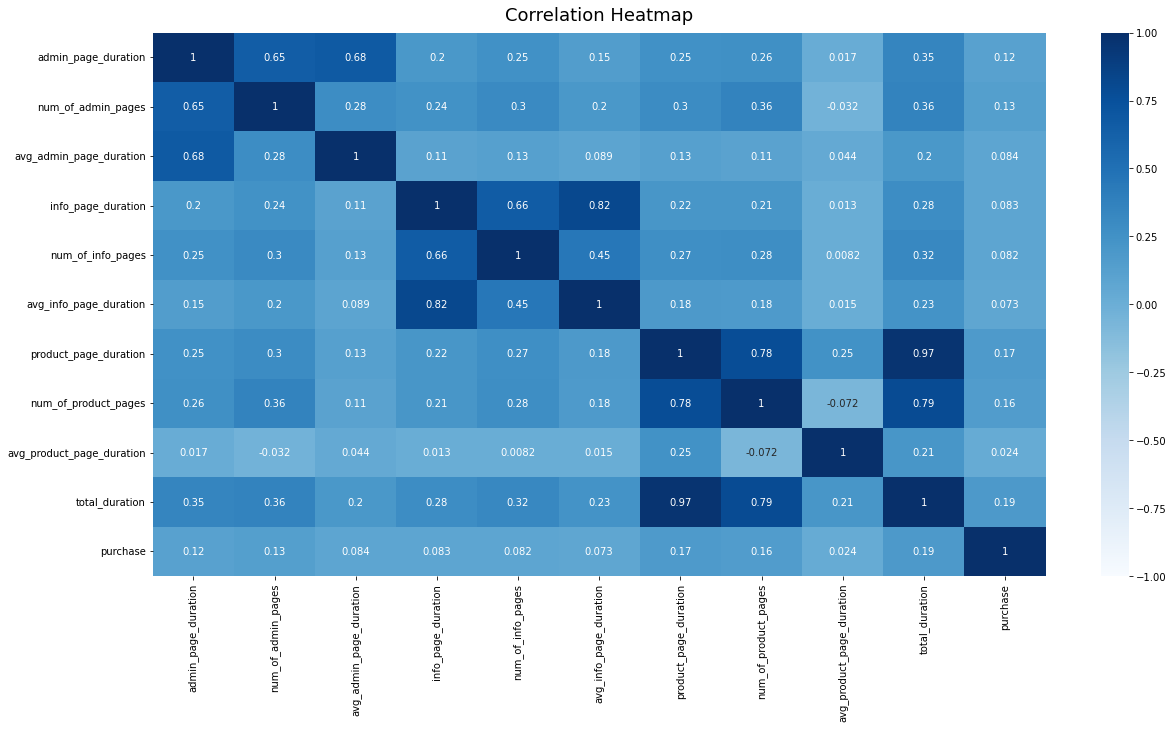

In [35]:
plot_corr_heatmap(all_page_features.columns,20,10)

The Heatmap below shows the correlation between the time features. Averaging each page type did help to reduce correlation among the features, but also reduced the correlation with the label. Combining this with the previous heatmap which shows neagtive correlation to some extent of total duration with ExitRates and BounceRates (users who have longer duration bounce/exit less), I chose to focus on the average values and ommit total duration from the models.

### 2.3 Exploring Bounce Rates, Exit Rates & Pages Value

**Exit rates, bounce rates**

In [36]:
rates = df[['ExitRates','BounceRates']]

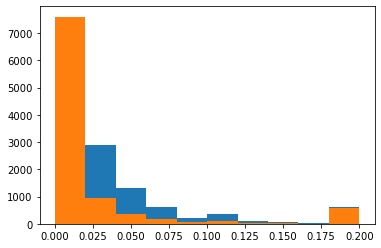

In [37]:
plot_histogram(rates)

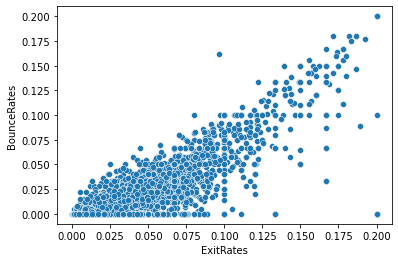

In [38]:
plot_scatterplot(df, 'ExitRates', 'BounceRates')

We can see that Bounce Rates and Exit Rates behave in a similar way (and are 90% correlated), which hints that there might be redundancy using both in the models. The scatter plot shows that there are some outliers (left upper corner and right-bottom corner) and I removed them in order to avoid that they create bias in the prediction. Below the plot after removing outliers.

In [39]:
# remove outliers on right-bottom and top-left corners
df.drop(df.loc[(df['BounceRates']<0.025)&(df['ExitRates']>=0.2)].index, inplace=True)
df.drop(df.loc[(df['BounceRates']>0.150)&(df['ExitRates']>0.09)].index, inplace=True)

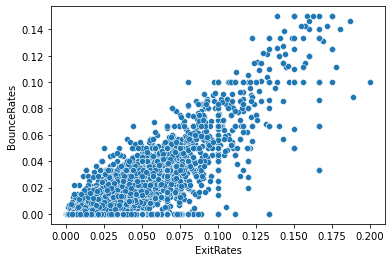

In [40]:
plot_scatterplot(df, 'ExitRates', 'BounceRates')

**Page values**

Pages value has similar distribution, but no major outliers that I consider as must-be-removed.

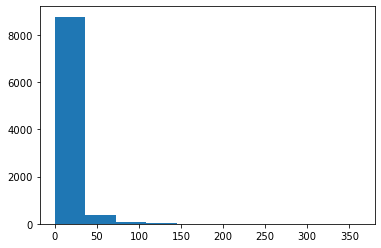

In [41]:
plot_histogram(['PageValues'])

The missing values in all three columns are insignificant, so I will simply fill them with medians:

In [42]:
# fill NaN bounce rates with median 
bounce_med = compute_median('BounceRates')
fill_nans(df,'BounceRates',bounce_med)

# fill NaN exit rates with median
exit_med = compute_median('ExitRates')
fill_nans(df,'ExitRates',exit_med)

# fill NaN page values with median
page_values_med = compute_median('PageValues')
fill_nans(df,'PageValues',page_values_med)

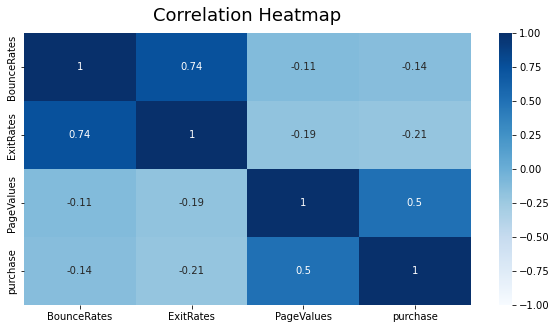

In [43]:
rates = rates + df[['PageValues','purchase']]
plot_corr_heatmap(rates.columns,10,5)

Over 90% correlation of exit and bounce rates. In a way, they refer to the same thing (https://support.google.com/analytics/answer/2525491?hl=en) -Exit rates refers to the percentage of the last pageviews in the session and Bounce Rateis the percentage of a page being the only one in the session (users behaviour is similar- either they exit after a short time and thus less pages or the opposite). Exit rate has high impact on whether a user will make a purchase or not, thus I will keep it. <br>
Page Value is the average value for a page that a user visited before landing on the goal page or making a transaction (purchase). This also explains the correlation with purchase- the higher the page value is the more likely that a user will make a purchase.

### 2.4 Exploring Weekend, Month & Closeness to Holiday

**Weekend**

In [44]:
df['Weekend'].value_counts()

False    7148
True     2165
Name: Weekend, dtype: int64

Comparing weekend to weekdays is somewhat misleading, as weekdays spread over 5 days while weekend over only two. Thus, I would like to plot purchase made over the weekend vs. weekday by percentage. Generally, we would expect that users will make more purchases over the weekend since they have more free time. The graph below shows that, in fact, users actually behave in a similar way, with a tendency for weekdays- around 85% of the user make a purchase oduring the week and around 82% over the weekend. This could be explained by the easiness of buying online comparing to on-site purchases.

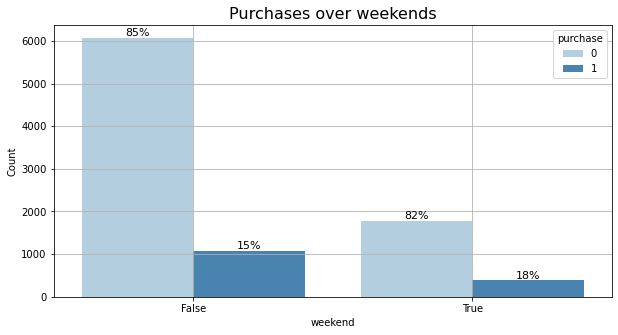

In [45]:
plot_countplot_percentage(df,'Weekend','purchase',10,5,'weekend','purchase','Purchases over weekends', True)

To ease the use of weekend feature, I will encode it to 0 or zero (boolean values) since all we wish to know here is if it was a weekend or not. I will fill the missing values with the most common value since this is a categorial feature and tere is insignificant amount of nans.

In [46]:
# convert to 0-1 values
df['weekend_encoded']=(df['Weekend']*1).astype('float')

In [47]:
# fill missing values with the most common value 0
fill_nans(df,'weekend_encoded',0)

**Month**

In [48]:
df['Month'].value_counts()

May     2589
Nov     2186
Mar     1448
Dec     1305
Oct      433
Sep      349
Aug      333
Jul      326
June     207
Feb      134
Name: Month, dtype: int64

Also here, I will fill with the most common month, according to their appearance.

In [49]:
# fill missing values with either May or November
df.loc[(df['Month'].isna()),'Month']= np.random.choice(['May','Nov'], size=None, replace=True, p=[0.5,0.5])

In [50]:
# converting month to number (float)
m_date = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'June':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
df['month_key'] = map_values(df, 'Month', m_date)

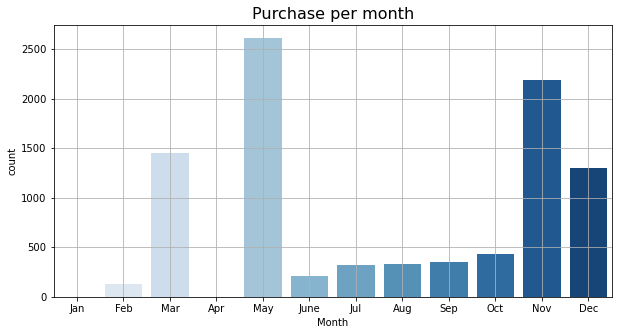

In [51]:
plot_months_by_order(df, 'Month')

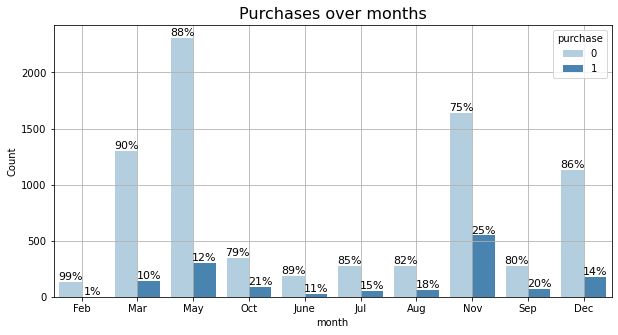

In [52]:
plot_countplot_percentage(df,'Month','purchase',10,5,'month','purchase','Purchases over months', True)

Wo do see that there is some seasonal behaviour over the months, with May, November, March being the stronger months (and January, April being very weak). In terms of ratio, during February, March and June users tend more towards making a purchase than in other months. For now, I believe that splitting the months into quarters and encoding them as dummy variables may be a better represenatation for this feature's behaviour. I will keep all options for now, but first fill the missing values according to the most common months.

In [53]:
# converting month to quarter
m_q = {'Jan':'Q1', 'Feb':'Q1', 'Mar':'Q1', 'Apr':'Q2', 'May':'Q2', 'June':'Q2', 'Jul':'Q3', 'Aug':'Q3', 'Sep':'Q3', 'Oct':'Q4', 'Nov':'Q4', 'Dec':'Q4' }
df['quarter'] = map_values(df, 'Month', m_q)

In [54]:
# create dummy variable for quarter
df = df.join(pd.get_dummies(df['quarter']))

**Closeness to holiday** 

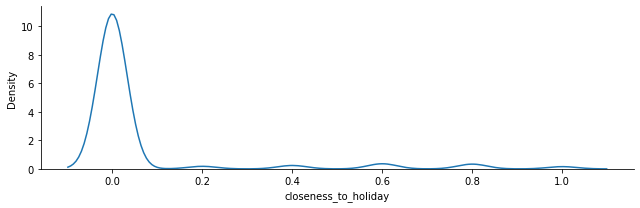

In [55]:
plot_distribution(['closeness_to_holiday'])

This feature is positively skewed. I will first fill the missing values with the median and later explore it with relation to other time-related features.

In [56]:
# fill NaN closeness_to_holiday with median 
holiday_med = compute_median('closeness_to_holiday')
fill_nans(df,'closeness_to_holiday',holiday_med)

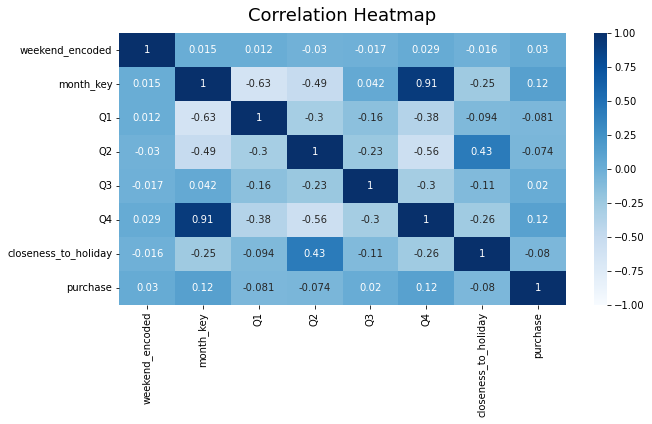

In [57]:
plot_corr_heatmap(['weekend_encoded','month_key','Q1','Q2','Q3','Q4','closeness_to_holiday','purchase'],10,5)

From first impression it seems that closeness to holiday is positively correlated with Q2 (April-June months) and negatively correlated with Q3 (July-September) and Q4 (October-December). Month key is highly correlated with most of the features and has the highest correlation with the label and thus I prefer to use it over the other features plotted.

### 2.5 Exploring User Characteristics

**Browser**

We are only interested to know the type of browser used, independent of the version and thus we will extract its name to a new column.

In [58]:
# extracting browser name
df['browser_name'] = df['internet_browser'].str.split('_').str[0]

In [59]:
df['browser_name'].value_counts()

chrome     5695
safari     1740
browser     868
edge        533
Name: browser_name, dtype: int64

The 'browser' category is unknown, probably since users often block the access to cookies or use VPN. I will continue the same logic and create an 'unknown' category for this categorial feature, both for 'browser' and for missing values as I have no way to track them back.

In [60]:
# change 'browser' values, as well as nan ones to unknown
fill_category_unknown(df,'browser_name','browser','unknown')

In [61]:
#create dummy variable for browser type
df = df.join(pd.get_dummies(df['browser_name']))

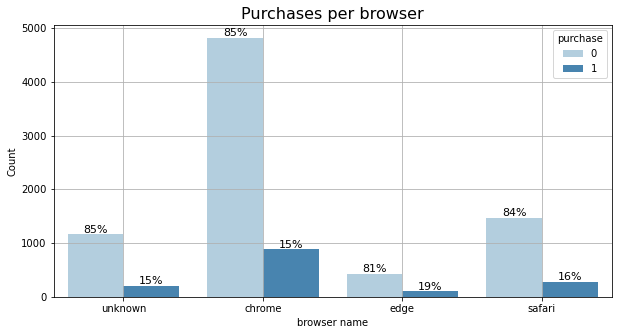

In [62]:
# plot percentage of purchase per browser
plot_countplot_percentage(df,'browser_name','purchase',10,5,'browser name','purchase','Purchases per browser', True)

Even though Chrome is the most popular browser, it seems that the percentages of purchase are well kept over the different browsers (with a slight tendencay for chrome and safari users to make purchases).

**Device**

In [63]:
df['device'].value_counts()

2.0    4861
1.0    1893
3.0    1863
4.0     362
8.0      53
6.0      14
5.0       4
7.0       1
Name: device, dtype: int64

This is a categorial feature and I chose to fill missing values with the median, whihc in this case is the most common device too.

In [64]:
# fill NaN of device with median 
device_med = compute_median('device')
fill_nans(df,'device',device_med)

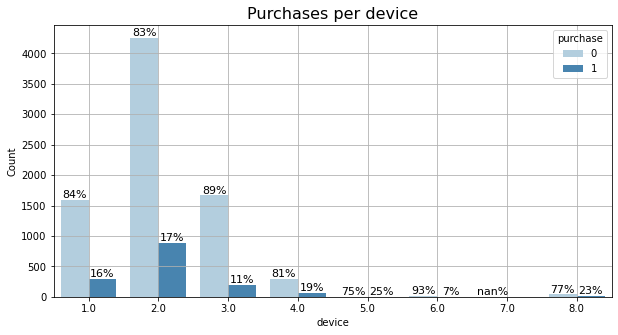

In [65]:
# plot percentage of purchase per device
plot_countplot_percentage(df,'device','purchase',10,5,'device','purchase','Purchases per device', True)

When referring to the device, there is more varience in terms of making transactions among the different devices. The most populare are 2, 1 and 3 and they account for almost 85% of the observations.

**Combination of browser and device**

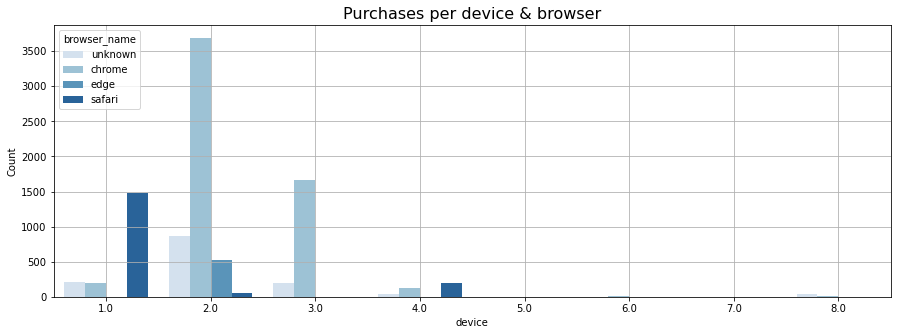

In [66]:
plot_countplot_percentage(df,'device','browser_name',15,5,'device','browser name','Purchases per device & browser', False)

Based on the assumptions that:
1. Chrome is very common amongst desktop users.
2. Safari is very common amongst iphone users.
3. Edge browser is more popular among laptop/tablet users and is barely in use in mobile phones.<br>

and combining with the graphs above I would assume that device 2 is probably desktop, device 1 is probably mobile/tablet and device 3 might be some kind of connected TV (source: device table, openRTB API specification (page 51), https://www.iab.com/wp-content/uploads/2016/03/OpenRTB-API-Specification-Version-2-5-FINAL.pdf).<br>

To emphasize the relationship betwen the type of device and the browser that is being used, I would like to create a new feature combining the two. I will rank the browsers and devices by their frequency and then will multiply both to show a stronger relationship of using a common browser and a common device (which in most cases go hand in hand).

In [67]:
# ranking browser type to multiply by device
m_browser_num = {'unknown':0, 'edge':1, 'safari':2, 'chrome':3}
df['browser_encoded'] = map_values(df,'browser_name', m_browser_num)

# ranking device type to multiply by device
m_device_num = {7.0:1,5.0:2,6.0:3,8.0:4,4.0:5,3.0:6,1.0:7,2.0:8}
df['device_encoded'] = map_values(df,'device', m_device_num)

# create new variable
df['browser_device'] = df['browser_encoded']*df['device_encoded']

The values here don't say much, we only care if one session is bigger than the other. Thus, I will normalize the feature (min-max).

In [68]:
# Normalizing the values of browser_device column between 0 to 1
df['browser_device_normalized'] = normalize_feature(df,'browser_device')

**User type**

In [69]:
df['user_type'].value_counts()

Returning_Visitor    7872
New_Visitor          1383
Other                  57
Name: user_type, dtype: int64

Since ther are only ~20 missing values, and since we already have 'other' category, I will simply complete missing user type with 'Other'. This is a categorical variable which I would like to convert to a dummy one. 

In [70]:
# change 'other' and complete missing user type with 'unknown'
fill_category_unknown(df, 'user_type','Other','other')

In [71]:
#create dummy variable for user type
df = df.join(pd.get_dummies(df['user_type']))

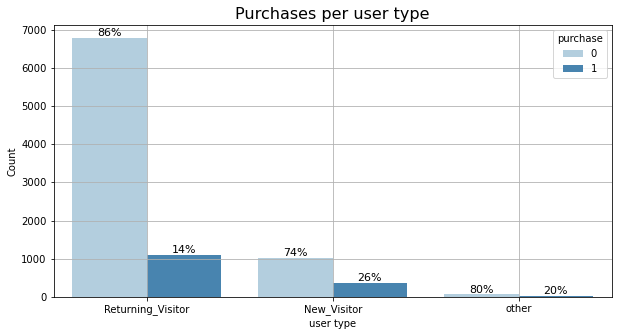

In [72]:
# plot percentage of purchase per user type
plot_countplot_percentage(df,'user_type','purchase',10,5,'user type','purchase','Purchases per user type', True)

We can tell that returning users make more purchases than new ones. Below we can see that they are almost fully correlated, but negatively.

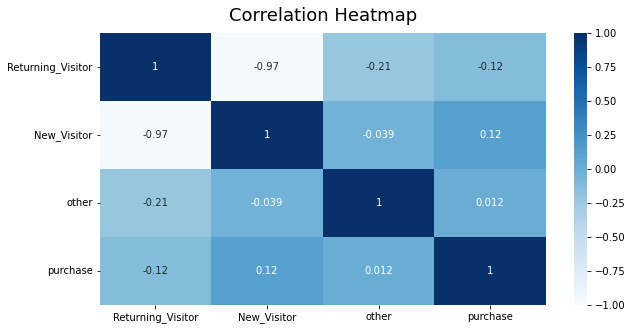

In [73]:
plot_corr_heatmap(['Returning_Visitor','New_Visitor','other','purchase'],10,5)

**Region**

In [74]:
df['Region'].value_counts()

1.0    3595
3.0    1816
4.0     880
2.0     837
6.0     632
7.0     592
9.0     383
8.0     337
5.0     245
Name: Region, dtype: int64

Region is a categorical variable. We cannot colclude from the data that we have if the regions are worldwide regions or in the USA solely. Since there are only ~20 blank regions, we can safely apply the most common region.

In [75]:
# fill na of region with region 1
fill_nans(df,'Region',1)

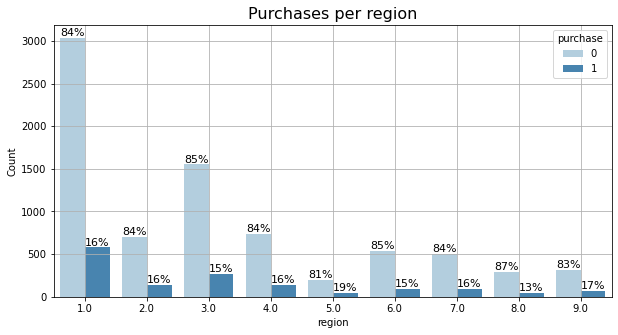

In [76]:
# plot percentage of purchase per user type
plot_countplot_percentage(df,'Region','purchase',10,5,'region','purchase','Purchases per region', True)

Region 1 is the most popluar one where most users come from. Across the regions users behave in the same way when deciding to make a purchase (around 85% making purchase against not at all). This might be due to the fact that all regions relate to the same country/geographical location. This similar behaviour might also indicate that there is a low variance in this feature. Thus, I prefer to leave this feature as is without making any further normalization/manipulation.

### 2.6 Exploring Anonymous Columns

**A**

In [77]:
df['A'].value_counts()

c_2        2806
c_1        1658
c_3        1445
c_4         797
c_13        495
           ... 
c_20_44       1
c_20_28       1
c_20_95       1
c_20_8        1
c_20_23       1
Name: A, Length: 91, dtype: int64

Column 'A'  gives some indication for page number (maybe the last page visited), but I'm not fully sure and thus I will only encode it to its relevant number. I will extratc for each page its number (pages with sub-page were given the number of the main page due to their insignificant amount) and fill missing values with the three most common values.

In [78]:
# extracting page number
df['A_num'] = (df['A'].str.split('_').str[1]).astype('float')

In [79]:
# filling nan values with the most common values according to their appearance
df.loc[(df['A_num'].isna()),'A_num']= np.random.choice([2,1,3], size=None, replace=True, p=[0.435,0.3,0.265])

**B**

This column is distributed normally and can be plotted with a plot box to show outliers. I will remove only extreme outliers that are outside the 1%-99% range.

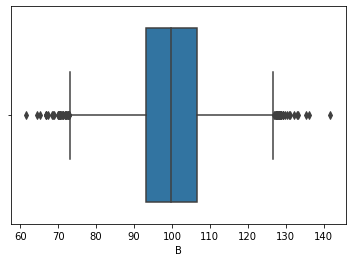

In [80]:
sns.boxplot(x=df['B'])
plt.show()

In [81]:
# outlier removal
q_low = df['B'].quantile(0.01)
q_hi  = df['B'].quantile(0.99)

df = df[(df['B'] < q_hi) & (df['B'] > q_low)]

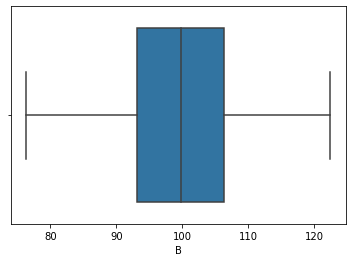

In [82]:
sns.boxplot(x=df['B'])
plt.show()

Outliers removed. I will fill missing values with the mdeian.

In [83]:
# fill NaN of B with median 
B_med = compute_median('B')
fill_nans(df,'B',B_med)

The column is anonymous and the values range between 60-141. I cannot conclude anything about their measure or distribution at this stage, so will normalize the column to values between 0-1 to have a better measure for the values (simply assuming that higher is better).

In [84]:
# Normalizing the values of 'B' column between 0 to 1
df['B_normalized'] = normalize_feature(df,'B')

**C**

In [85]:
df['C'].value_counts()

log200     1567
log8080    1542
log400     1533
log404     1512
log_100    1504
log202     1454
Name: C, dtype: int64

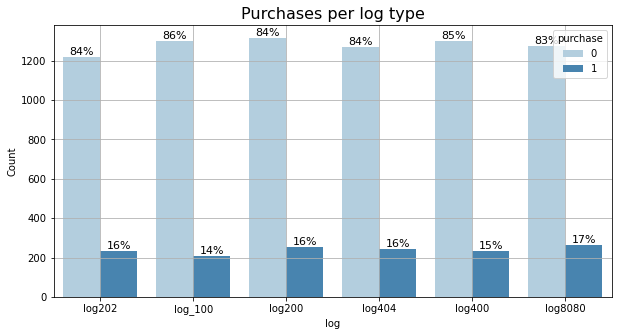

In [86]:
# plot percentage of purchase per log type
plot_countplot_percentage(df,'C','purchase',10,5,'log','purchase','Purchases per log type', True)

I assume this feature is HTTP errors. According to HTTP response status codes (https://www.iana.org/assignments/http-status-codes/http-status-codes.xhtml) I estimate that the different messages mean:
- log_100 = "Continue"
- log200 = "Ok"
- log202 = "Accepted"
- log400 = "Bad Request"
- log404 = "Not Found"
- log8080 = "Cannot Access Local Server"<br>

From the graph it seems that in most cases there was no purchase made.Assuming that errors in the purchase process may effect final decision, I would like to categorize this categorial feature to 'yes' error or 'no' error.

In [87]:
http_err = {'log_100':0, 'log200':0, 'log202':0, 
            'log400':1, 'log404':1, 'log8080':1}
df['C_encoded'] = map_values(df,'C', http_err)

There're only ~10 missing values, so we will fill them keeping the same ratio of around 50%-50%.

In [88]:
df.loc[(df['C_encoded'].isna()),'C_encoded']= np.random.choice([0,1], size=None, replace=True, p=[0.50,0.5])

Create a dummy variable to understand if a logged error in the process changed user decision to make a purchase.

In [89]:
#create dummy variable- error or not
df[['no_error','yes_error']] = pd.get_dummies(df['C_encoded'])

**D**

In [90]:
df['D'].isna().sum()

9029

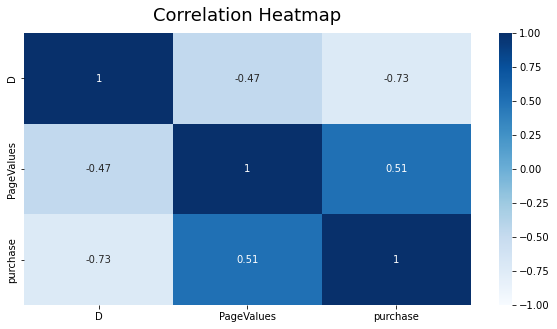

In [91]:
plot_corr_heatmap(['D','PageValues','purchase'],10,5)

Column D has over 90% missing values. When I observe column it, it seems that there is a high negative correlation with purchase and page values column. So this feature could be a very important one. Having said that, I lack the tools to fill the missing values based on knowledge gained so far. I will encode it to 0-1 values in order to understand if the missing values can add valuable information to the models.

In [92]:
df['D_encoded'] = df['D'].notnull().astype('int')

### 2.7 Dimensionality Reduction

In [93]:
print(f'Number of features in the current dataframe: {len(df.columns)}')

Number of features in the current dataframe: 50


As for now, the dimensionality of the problem is too big. 50 features that explain ~10,000 sessions, many are repetitive or correlated among them is not recommended and can cause several problems:
1. Using correlated features can make the model be repetitive and not add much useful information.
2. Difficult to analyze so many features and conclude how each and every one of them contributes to the model.
3. Increasing data dimensions might cause the 'Curse of Dimensionality' with more features adding more noise (increasing error).
4. Risk for overfitting when the model fits almost perfectly to the given train data (but might not behave in the same way for the test data).
5. High computational power and algorithm complexity. <br>

Thus, I will use the PCA method to reduce dimensions.


**Initial dimension reduction**

First I will remove repetitive features and categorail ones whihch can be plotted on the heatmap.

In [94]:
features_after_initial_filtering = ['admin_page_duration','num_of_admin_pages','avg_admin_page_duration',
                                    'info_page_duration','num_of_info_pages','avg_info_page_duration',
                                    'product_page_duration','num_of_product_pages','avg_product_page_duration',
                                    'total_duration','ExitRates','PageValues',
                                    'closeness_to_holiday','month_key','Q1','Q2','Q3','Q4','weekend_encoded',
                                    'chrome','safari','edge','unknown','device','browser_encoded','device_encoded', 
                                    'browser_device','browser_device_normalized',
                                    'Returning_Visitor', 'New_Visitor', 'other','Region',
                                    'A_num','B','B_normalized','C_encoded','no_error','yes_error','D_encoded','purchase']

In [95]:
print(f'Number of features after initial selection: {len(features_after_initial_filtering)-1}')

Number of features after initial selection: 39


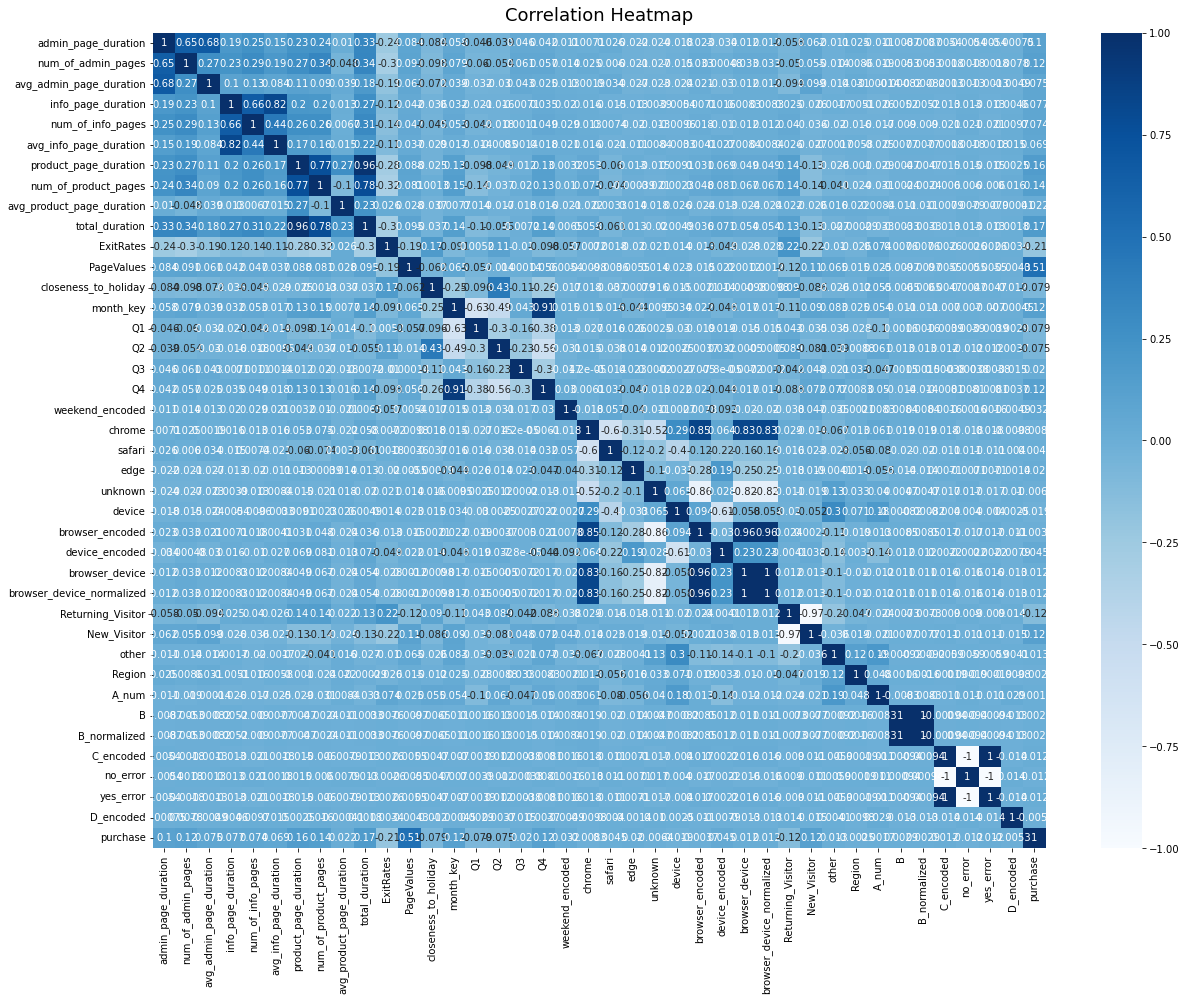

In [96]:
plot_corr_heatmap(features_after_initial_filtering,20,15)

1. Closeness to holiday is correlated with some of the quarters. Q4 is correlated with Q4. I will have to chose one parameter to represent season trends.
2. Durations are still highly correlated, taken as is.
3. Rturning visitor is highly correlated (negative) with New Visitor. Also here I will prefer to use only one of them. Other user is correlated with device.
4. The different browser types are also highly correlated and thus I do not recommend to use these dummy variable. They are also, obviously, correlated with browser. The browser_device feature might be a good way to empahsize the connection but reduce correlation.
5. The errors are fully correlated with C-encoded, and I tend to leave out the encoded feature.

**Dimensionality reduction with PCA**

As shown before, the data is unblanaced, so I will split it to train and test.

In [97]:
# split the data to train and test
X_train, X_test, y_train, y_test = split_train_test_chosen_features(df,features_after_initial_filtering,'purchase')

In [98]:
# standardize the data before applying PCA
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [99]:
# PCA all features
pca = PCA(n_components=X_train.shape[1])
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

components = pca.components_
print(f'Number of features in the model: {len(features_after_initial_filtering)-1}')
print(f'Number of features removed: {len(features_after_initial_filtering)-len(components)}')

Number of features in the model: 39
Number of features removed: 0


The PCA model did not reduce the dimensionality at all, this may happen since there are not many redundancies in the features. The dimension is still too big to keep trainig the models without worrying about overfitting. Thus, I will use the filter method to reduce dimensionality and combine it with knowledge gained so far abuot the features and their mututal behavior.

**Dimensionality reduction - filter method** <br>

Here I will reduce features in a combined analysis of reducing correlated features, removing features with a vey low variance (if the observations behave in the same way then the contribution to the model is very low too) and will keep features that are correlated with the label and represent the data set appropriately (based on conclusions from the data exploration). <br>
From the heatmap above, top features that are correlated with the label are:
- PageValues
- Total_duration
- product_page_duration
- New_Visitor
- num_of_product_pages
- month_key
- D
- ExitRates
- BounceRates
- Returning_Visitor <br>

I will look into the variance of the features:

In [100]:
# check features with low variance
threshold = 0.8 * (1 - 0.8)
df[features_after_initial_filtering].var()<(threshold)

admin_page_duration          False
num_of_admin_pages           False
avg_admin_page_duration      False
info_page_duration           False
num_of_info_pages            False
avg_info_page_duration       False
product_page_duration        False
num_of_product_pages         False
avg_product_page_duration    False
total_duration               False
ExitRates                     True
PageValues                   False
closeness_to_holiday          True
month_key                    False
Q1                            True
Q2                           False
Q3                            True
Q4                           False
weekend_encoded              False
chrome                       False
safari                        True
edge                          True
unknown                       True
device                       False
browser_encoded              False
device_encoded               False
browser_device               False
browser_device_normalized     True
Returning_Visitor   

Features with low variance that one should consider removing are: 
- ExitRates
- closeness_to_holiday
- Q1
- Q3
- safari
- edge
- unknown
- Returning_Visitor
- New_Visitor
- other 
- D_encoded <br>

I will ignore the low variance of browser_device_normalized and B_normalized since I normalized them for the model.

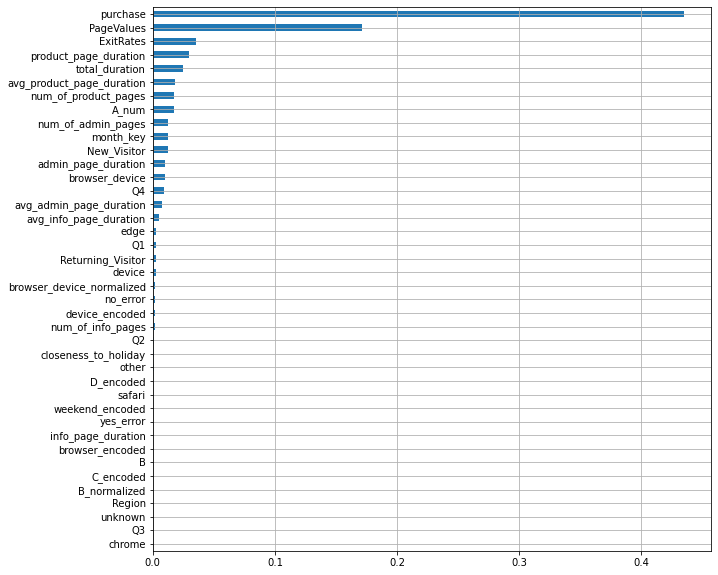

In [101]:
plot_all_feature_importance(df,features_after_initial_filtering, 'purchase')

The most important features according to the graph are: 
- PageValues
- ExitRates
- product_page_duration
- total_duration
- avg_product_page_duration
- num_of_product_pages
- month_key
- admin_page_duration
- Returning_Visitor
- A_num
- device_encoded
- info_page_duration

After analyzing with PCA and few methods, I found that the best way was selecting the features one by one, manualy. Combining all the bove, I find that the following 13 features represent the data set well, avoid high correlation and are not too similar among sessions:

In [102]:
# reduced features based on correlation and data exploration above:
chosen_features = ['avg_admin_page_duration','avg_info_page_duration','avg_product_page_duration',
                    'ExitRates','PageValues','Returning_Visitor','weekend_encoded','month_key','browser_device_normalized',
                    'Region','A_num','B_normalized','C_encoded']

In [103]:
# split according to new features
X_train, X_test, y_train, y_test = split_train_test_chosen_features(df,chosen_features,'purchase')

# Normalize the data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

**Test data pre-processing**

In [104]:
# load the test data
df_test = pd.read_csv("test.csv", index_col=0)

In [105]:
df_test

,num_of_admin_pages,admin_page_duration,num_of_info_pages,info_page_duration,num_of_product_pages,product_page_duration,total_duration,BounceRates,ExitRates,PageValues,...,Month,device,internet_browser,Region,user_type,Weekend,A,B,C,D
id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.00,0.0,0.0 minutes,2.0,64.0 minutes,NaN,0.000000,0.100000,0.0,...,Feb,2.0,chrome_99.1.3,1.0,Returning_Visitor,False,c_2,92.487250,log200,NaN
1,0.0,0.00,0.0,0.0 minutes,2.0,2.666666667 minutes,NaN,0.050000,0.140000,0.0,...,Feb,3.0,chrome_98.0.1,2.0,Returning_Visitor,False,c_4,120.493478,log400,NaN
2,1.0,0.00,0.0,0.0 minutes,0.0,NaN,0.000000,0.200000,0.200000,0.0,...,Feb,1.0,chrome_99.1.3,1.0,Returning_Visitor,True,c_5,94.120580,log400,NaN
3,0.0,NaN,0.0,0.0 minutes,2.0,32.0 minutes,32.000000,0.000000,0.100000,0.0,...,Feb,2.0,chrome_90.1.7,1.0,Returning_Visitor,False,c_3,115.990484,log8080,NaN
4,0.0,0.00,0.0,0.0 minutes,4.0,63.0 minutes,NaN,0.000000,0.050000,0.0,...,Feb,2.0,browser_6_v12,1.0,Returning_Visitor,False,c_3,93.866618,log404,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,0.0,0.00,0.0,0.0 minutes,3.0,35.0 minutes,35.000000,0.000000,0.066667,0.0,...,Nov,4.0,safari_13,1.0,Returning_Visitor,False,c_1,90.187780,log200,NaN
1847,0.0,0.00,0.0,0.0 minutes,5.0,108.0 minutes,NaN,0.000000,0.040000,0.0,...,Dec,2.0,chrome_99.1.4,1.0,New_Visitor,False,c_2,110.914752,log_100,NaN
1848,0.0,0.00,0.0,0.0 minutes,39.0,1168.619841 minutes,1168.619841,0.000000,0.009064,0.0,...,Nov,1.0,safari_14.1,4.0,Returning_Visitor,False,c_3,113.442371,log200,NaN


In [106]:
df_test_processed = preprocessing(df_test)

In [107]:
X_test_final = df_test_processed.drop(columns=[col for col in df_test_processed if col not in chosen_features])

In [108]:
X_test_final

,ExitRates,PageValues,Region,avg_admin_page_duration,avg_info_page_duration,avg_product_page_duration,weekend_encoded,month_key,browser_device_normalized,Returning_Visitor,A_num,B_normalized,C_encoded
id,,,,,,,,,,,,,
0,0.100000,0.0,1.0,0.000,0.0,32.000000,0,2,1.000000,1,2.0,0.367536,0.0
1,0.140000,0.0,2.0,0.000,0.0,1.333333,0,2,0.750000,1,4.0,0.789568,1.0
2,0.200000,0.0,1.0,0.000,0.0,0.000000,1,2,0.875000,1,5.0,0.392149,1.0
3,0.100000,0.0,1.0,0.000,0.0,16.000000,0,2,1.000000,1,3.0,0.721711,1.0
4,0.050000,0.0,1.0,0.000,0.0,15.750000,0,2,0.000000,1,3.0,0.388322,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,0.066667,0.0,1.0,0.000,0.0,11.666667,0,11,0.416667,1,1.0,0.332885,0.0
1847,0.040000,0.0,1.0,0.000,0.0,21.600000,0,12,1.000000,0,2.0,0.645224,0.0
1848,0.009064,0.0,4.0,0.000,0.0,29.964611,0,11,0.583333,1,3.0,0.683313,0.0


In [109]:
X_test_scale = pd.DataFrame(scaler.transform(X_test_final))

## 3. Prediction models

I chose the following models, which will work best with ouur type of data. The parameters were selected with GridSearch to find the best variation of parameters.

### 3.1 Logistic Regression

In [110]:
# create parameters dictionary for finding best parameter
powers = range(-10, 1)
Cs = [10**p for p in powers]
lr_params = {"C" : Cs, "penalty":["l1","l2"], "solver" : ['saga', 'liblinear']}

In [111]:
best_params_lr, best_score_lr = find_best_parameters(LogisticRegression(), lr_params, X_train, y_train)
lr, y_lr_pred, test_acc_score_lr = logistic_regression_model(best_params_lr, X_train, y_train, X_test, y_test)
train_test_diff_lr = calculate_difference_in_train_test_score(test_acc_score_lr,best_score_lr)

print_model_results('LogisticRegression',best_params_lr,best_score_lr,test_acc_score_lr,train_test_diff_lr,True)

Best hyperparameters for LogisticRegression model are: {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}

Train best score is: 0.892 and test accuracy score is: 0.886

The difference between the train and test score is: 1.0%.

Risk of overfitting? False


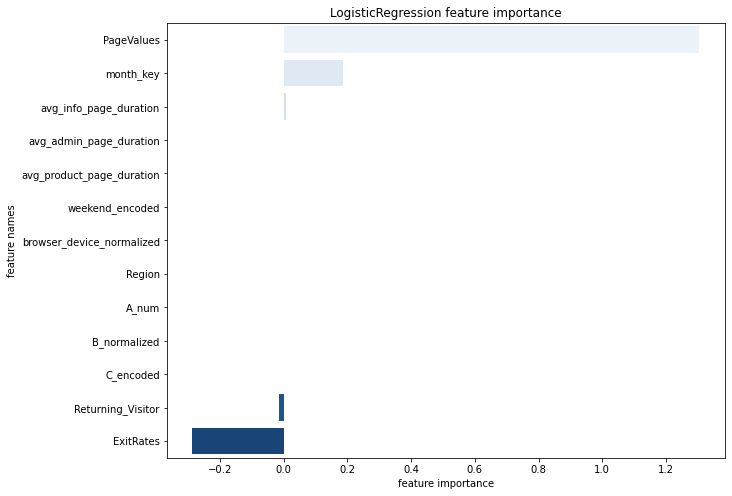

In [112]:
# plot feature importance for LR classifier
feature_importance_lr = lr.coef_[0]
plot_feature_importance(feature_importance_lr, chosen_features, 'LogisticRegression')

Pages Values is the most valuable feature value for this model and is very insightful in predicting if a session will end up in a purchase. Month key to follow, which indicates that some months are more attractive to purchase than others. On this point I wish to make a concern that since this is a regressoin model, the mapped values of 1-12 might create bias in the model since later months get higher weight. <br>

Exit Rates impacts negatively and has a huge impact on user's decision **not** to make a purchase. With a little importnace, but it seems that returning visitor might also impact the decision not to make a purchase.

### 3.2 Naive Bayes Classifier

In [113]:
best_score_nb, test_acc_score_nb = gaussian_naive_bayes_model(X_train, y_train, X_test, y_test)
train_test_diff_nb = calculate_difference_in_train_test_score(test_acc_score_nb,best_score_nb)

print_model_results('GaussianNB',0,best_score_nb,test_acc_score_nb,train_test_diff_nb,False)

Train best score is: 0.871 and test accuracy score is: 0.875

The difference between the train and test score is: 0.0%.

Risk of overfitting? False


This model has the lowest score of all 4. The model assumes that the features are independent, and the presence of one is not related to the other. This is not the case, and the model results leads me to the conclusion that there is a strong interaction and dependancy between features and users decision to spend money and make  apurchase.

### 3.3 Random Forest Classifier

In [114]:
# create parameters dictionary for finding best parameter
rf_params = {'n_estimators': [70,80,90], 
            'criterion': ['gini', 'entropy','log_loss'],
            'max_depth': [200, 300],
            'min_samples_leaf' : [3, 4, 5],
            'max_features' : [4, 8],
            'random_state': [0]}

In [115]:
best_params_rf, best_score_rf = find_best_parameters(RandomForestClassifier(), rf_params, X_train, y_train)
rf, y_rf_pred, test_acc_score_rf = random_forest_classifier_model(best_params_rf, X_train, y_train, X_test, y_test)
train_test_diff_rf = calculate_difference_in_train_test_score(test_acc_score_rf,best_score_rf)

print_model_results('RandomForestClassifier',best_params_rf,best_score_rf,test_acc_score_rf,train_test_diff_rf,True)

Best hyperparameters for RandomForestClassifier model are: {'criterion': 'entropy', 'max_depth': 200, 'max_features': 8, 'min_samples_leaf': 5, 'n_estimators': 80, 'random_state': 0}

Train best score is: 0.921 and test accuracy score is: 0.906

The difference between the train and test score is: 2.0%.

Risk of overfitting? False


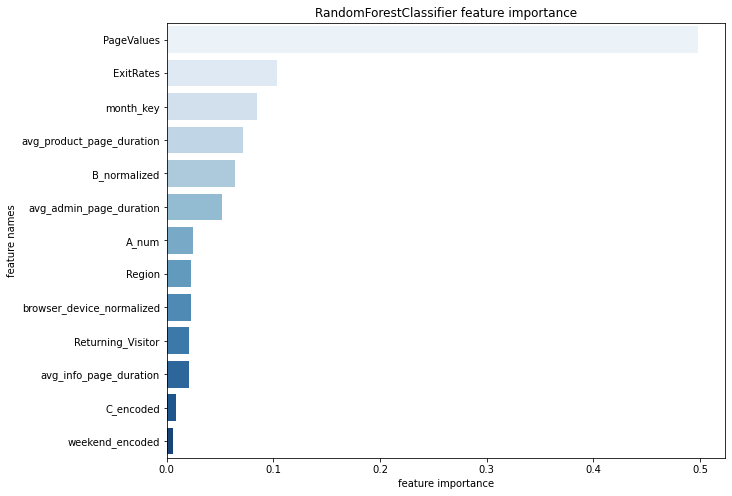

In [116]:
# plot feature importance for RF classifier
feature_importance_rf = rf.feature_importances_
plot_feature_importance(feature_importance_rf, chosen_features, 'RandomForestClassifier')

This graph approves what I assumed so far, that the time invested in a session (durations, exit rates) and money (pages value) are very critical to the purchase decision and the month which can also influence the sales or discounts before holidays or at the end of a season closeness to holiday did not give a good measure since there was no way to know if it was beofre or after holiday and in which season). The fact that it was a weekend has no great impact since e-commerce takes little effort from users and doesn't require much free time.<br>

Other users' features such as region, the combination of browser and device and returning users are mainly cultural and also affect his decision to end a session aith a purchase. <br>

Surprising is the importnace of feature B_normalized which seems to be very high, and A_num (column A , not sure but could be page number) that I was not able to track. Despite my first assumption, the presence of an error during a session had only a little impact on users.

### 3.4 MLP

In [117]:
# create parameters dictionary for finding best parameters
powers = range(-1,5)
alphas = [10**(p) for p in powers]
mlp_params = {'hidden_layer_sizes' : [(300,), (200,200)],
                    'activation' : ['relu', 'tanh'],
                    'alpha' : alphas,
                    'learning_rate_init' : [0.1, 0.01],
                    'learning_rate' : ['adaptive'],
                    'max_iter' : [2]}

In [118]:
best_params_mlp, best_score_mlp = find_best_parameters(MLPClassifier(), mlp_params, X_train, y_train)
mlp, y_mlp_pred, test_acc_score_mlp = MLP_classifier_model(best_params_mlp, X_train, y_train, X_test, y_test)
train_test_diff_mlp = calculate_difference_in_train_test_score(test_acc_score_mlp,best_score_mlp)

print_model_results('MLPClassifier',best_params_mlp,best_score_mlp,test_acc_score_mlp,train_test_diff_mlp,True)

Best hyperparameters for MLPClassifier model are: {'activation': 'relu', 'alpha': 1, 'hidden_layer_sizes': (200, 200), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 2}

Train best score is: 0.894 and test accuracy score is: 0.905

The difference between the train and test score is: 1.0%.

Risk of overfitting? False


The model does not give a straight-forward explanation to the importance of each feature, but I believe that the previous three models provided some good insights.

## 4. Model Evaluation

### 4.1 Confusion Matrix for RF model

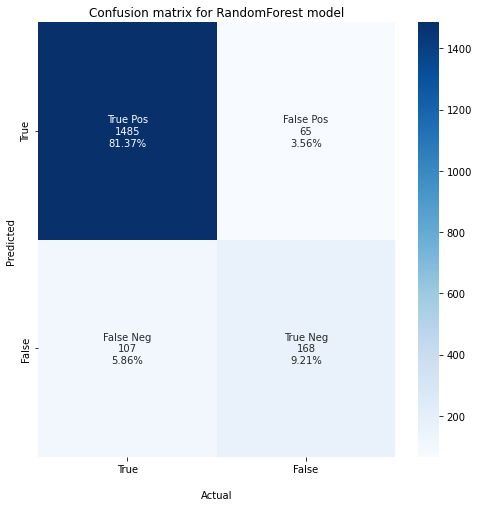

In [119]:
plot_confusion_matrix(y_test, y_rf_pred,'Confusion matrix for RandomForest model')

The Confusion Matrix explains the follows based on the LR model:
1. True Pos - the user made a purchase and the model predicted that he would do so (in 81% of the cases).
2. False Pos - the user made a purchase and the model predicted that he wouldn't do so (in 3.5% of the cases).
3. False Neg -  the user did not make a purchase but the model predicted that he would do so (in 5.6% of the cases).
4. True Neg - the user did not make a purchase but the RandomForest model predicted that he wouldn't do so (in 9.4% of the cases).

the accuracy of the model is ~91% (true prediction) and gives a good inight to e-commerce business manager about users' decision to make a purchase on the website. It is not only important to understand if users will make a purchase (TP), but also analyze the cases in which they decide not to make a purchase (TN) and improve the website or the service accordingly.

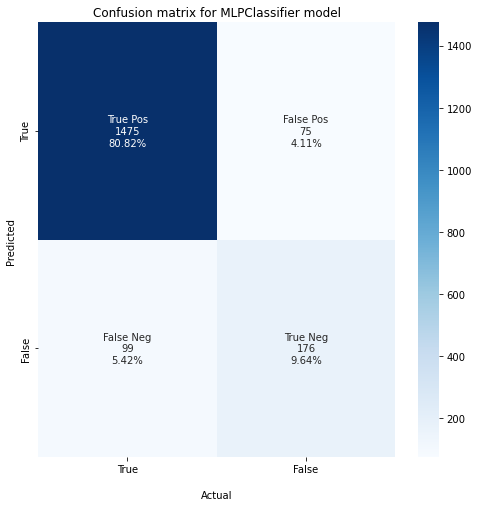

In [120]:
plot_confusion_matrix(y_test, y_mlp_pred,'Confusion matrix for MLPClassifier model')

I plot another confusion matrix that is based on the MLP model to show that both models performed similarly both for positive and negative true purchasing decisions. This might be another indicator that the models perform well, in relation to the features related to the label, and that they explain well the purchase process.

### 4.2 K-Fold Cross Validation

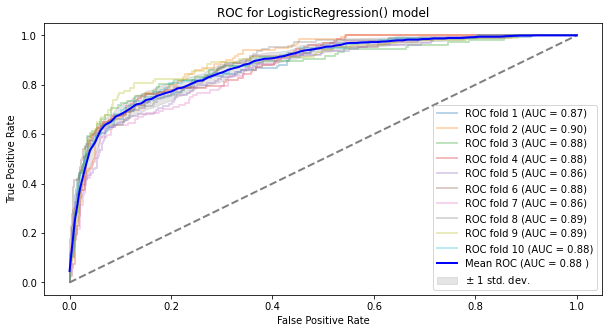

In [121]:
plot_ROC_Kfold(X_train.values,y_train.values,LogisticRegression(), 10)

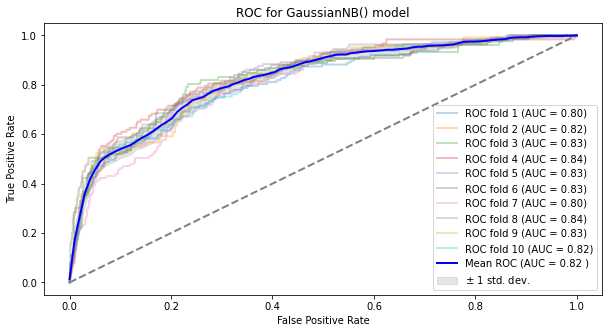

In [122]:
plot_ROC_Kfold(X_train.values,y_train.values,GaussianNB(), 10)

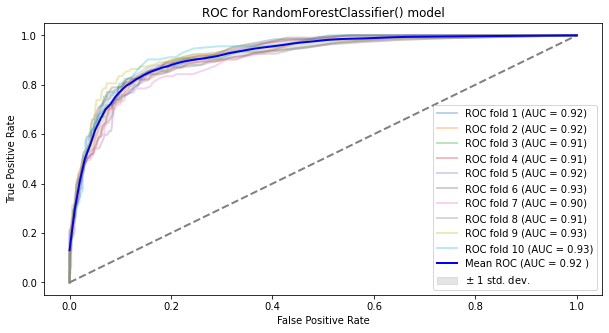

In [123]:
plot_ROC_Kfold(X_train.values,y_train.values,RandomForestClassifier(), 10)

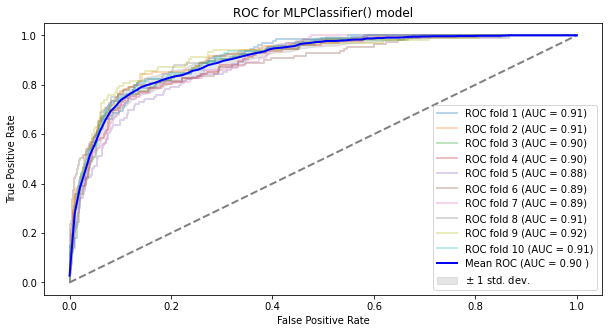

In [124]:
plot_ROC_Kfold(X_train.values,y_train.values,MLPClassifier(),10)

The ROC plots show overall a relative high accuracy for the models, with 82%-92% AUC, and RandomForestClassifier being the most successful one.

### 4.3 Overall evaluation and overfitting

In [125]:
Comparison_table = {'Model': ['Logistic Regression','Gaussian NB','Random Forest Classifier','MLP Classifier'],
                    'best score':[best_score_lr,best_score_nb,best_score_rf,best_score_mlp],
                    'accuracy':[test_acc_score_lr,test_acc_score_nb,test_acc_score_rf,test_acc_score_mlp],
                    'overfitting':['False','False','False','False']}

table = pd.DataFrame(data=Comparison_table)
table

,Model,best score,accuracy,overfitting
0,Logistic Regression,0.892121,0.886027,False
1,Gaussian NB,0.871198,0.875068,False
2,Random Forest Classifier,0.920851,0.905753,False
3,MLP Classifier,0.893684,0.904658,False


The best score is the score given to the train data. The accuracy is the score given to the test data. To check for overfitting I calculates the difference between the two scores and set a threshold of 2%. All four models don't cross this threshold.<br>

To avoid overfitting I treated correlated features and created new ones that are less correlated to represnt correlation, reduced the number of features significantly, normalized features and removed outliers in a careful way. by chosing conservative approach, I managed to select features set that is representative yet not repetitive. <br>

The chosen model is RandomForestClassifier with the highest best score and highest accuracy. This is a model that's simple to implement, predicting succesfully yet doesn't take too much runtime.

## 5. Prediction

In [126]:
rf_test = RandomForestClassifier(**best_params_rf)
rf_test.fit(X_train,y_train)

y_test_pred = rf_test.predict_proba(X_test_scale)[:,1]
test_pred = pd.DataFrame(y_test_pred, columns = ['predict_prob'])

test_pred.reset_index(inplace=True)
test_pred = test_pred.rename(columns = {'index':'id'})
test_pred

,id,predict_prob
0,0,0.014524
1,1,0.021607
2,2,0.027991
3,3,0.025774
4,4,0.014940
...,...,...
1846,1846,0.098537
1847,1847,0.055441
1848,1848,0.083575
1849,1849,0.003125


In [127]:
test_pred.to_csv('Submission_group_39.csv', index = False)

## 6. Pipeline

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

from numpy import interp
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings
warnings.filterwarnings('ignore')

In [4]:
# final features 
final_features = ['avg_admin_page_duration','avg_info_page_duration','avg_product_page_duration',
                    'ExitRates','PageValues','Returning_Visitor','weekend_encoded','month_key','browser_device_normalized',
                    'Region','A_num','B_normalized','C_encoded']

# create parameters dictionary for finding best parameter
rf_params = {'n_estimators': [70,80,90], 
            'criterion': ['gini', 'entropy','log_loss'],
            'max_depth': [200, 300],
            'min_samples_leaf' : [3, 4, 5],
            'max_features' : [4, 8],
            'random_state': [0]}

# function to convert str to float and remove 'minutes' str
def remove_min_str_to_float(dtframe,col):
    removed = dtframe[col].astype('str').str.replace('minutes','').astype(float)
    return removed   
        
# function to remove outliers from upper q% quantile on selected
def remove_outliers(dtframe, features_lst,q):
    data_original=dtframe.copy()    
    for feature in features_lst:
        dtframe.drop(dtframe.loc[dtframe[feature] > dtframe[feature].quantile(q)].index, inplace=True)
    return dtframe

# function to fill nan values with 0 (page features only)
def nan_to_zero(dtframe,duration_col, num_col):
    dtframe.loc[((dtframe[duration_col].isna())&(dtframe[num_col]==0)),duration_col]=0
    dtframe.loc[((dtframe[num_col].isna())&(dtframe[duration_col]==0)),num_col]=0

# function to compute median value, while ignring NaNs
def compute_median(col):
    med = df_train[col].median()
    return med

# function to fill nan values
def fill_nans(dtframe,col,value):
    dtframe.loc[(dtframe[col].isna()),col]= value
    
# get average duration per page rather than total duration and number of pages
def avg_duration_per_page(dtframe,duration_col,num_col):
    avg = (dtframe[duration_col]/dtframe[num_col]).replace([np.inf, -np.inf], np.nan).fillna(0)
    return avg

# function to map values
def map_values(dtframe, col, map):
    mapped_col = dtframe[col].map(map)
    return mapped_col
   
# function to fill categorial nans
def fill_category_unknown(dtframe, col,name,new_val):
    dtframe.loc[dtframe[col]==name,col]= new_val
    dtframe.loc[dtframe[col].isna(),col]= new_val
    
# function to normalize feature
def normalize_feature(dtframe,col):
    feature = (dtframe[col] - dtframe[col].min())/(dtframe[col].max() - dtframe[col].min())
    return feature

def process_string(dtframe):
    for feature in ['info_page_duration','product_page_duration']:
        dtframe[feature] =  remove_min_str_to_float(dtframe,feature)

#--------------------------------------------------------------------------------------------------------------------------
# support functions for test data preprocessing
def process_durations(dtframe,admin_col,info_col,product_col,
                      admin_col_num,info_col_num,product_col_num,
                      admin_duration_med,product_duration_med,info_duration_med,
                      num_admin_med,num_product_med,num_info_med):
    # fill nan based on 0 duration and number of pages
    nan_to_zero(dtframe,admin_col,admin_col_num)
    nan_to_zero(dtframe,info_col,info_col_num)
    nan_to_zero(dtframe,product_col,product_col_num)
    # fill nan values in page deatures with median 
    fill_nans(dtframe,admin_col,admin_duration_med)
    fill_nans(dtframe,product_col,product_duration_med)
    fill_nans(dtframe,info_col,info_duration_med)
    # fill nan values in number of pages with median 
    fill_nans(dtframe,admin_col_num,num_admin_med)
    fill_nans(dtframe,product_col_num,num_product_med)
    fill_nans(dtframe,info_col_num,num_info_med)
    # calculate average per page
    dtframe['avg_admin_page_duration']= avg_duration_per_page(dtframe,admin_col,admin_col_num)
    dtframe['avg_info_page_duration']=avg_duration_per_page(dtframe,info_col,info_col_num) 
    dtframe['avg_product_page_duration']=avg_duration_per_page(dtframe,product_col,product_col_num)

def process_weekend(dtframe,col,value):
    dtframe['weekend_encoded']=dtframe[col]*1
    fill_nans(dtframe,'weekend_encoded',value)
    
def process_month_key(dtframe, col, month1, month2,d_map):
    dtframe.loc[(dtframe[col].isna()),col]= np.random.choice([month1,month2], size=None, replace=True, p=[0.5,0.5])
    dtframe['month_key'] = map_values(dtframe, col, d_map)

def process_browser_device(dtframe, browser, browser_map, device, med, device_map):
    dtframe['browser_name'] = dtframe[browser].str.split('_').str[0]
    fill_category_unknown(dtframe,'browser_name','browser','unknown')
    dtframe['browser_encoded'] = map_values(dtframe,'browser_name', browser_map)
    fill_nans(dtframe,device,med)
    dtframe['device_encoded'] = map_values(dtframe,device,device_map)
    dtframe['browser_device'] = dtframe['browser_encoded']*dtframe['device_encoded']
    dtframe['browser_device_normalized'] = normalize_feature(dtframe,'browser_device')

def process_user_type(dtframe,col):
    fill_category_unknown(dtframe,col,'Other','other')
    
def process_A_num(dtframe, col):
    dtframe['A_num'] = (dtframe[col].str.split('_').str[1]).astype('float')
    # filling nan values with the most common values according to their appearance
    dtframe.loc[(dtframe['A_num'].isna()),'A_num']= np.random.choice([2,1,3], size=None, replace=True, p=[0.435,0.3,0.265])

def process_b_normalized(dtframe, col, med):
    fill_nans(dtframe,col,med)
    dtframe['B_normalized'] = normalize_feature(dtframe,col)
    
def process_c_encoded(dtframe, col, log_map):
    dtframe['C_encoded'] = map_values(dtframe,col,log_map)
    dtframe.loc[(dtframe['C_encoded'].isna()),'C_encoded']= np.random.choice([0,1], size=None, replace=True, p=[0.50,0.5])

    
    # final function to prep-process the data set
def preprocessing_pipeline(dtframe, d_type,final_features):
    process_string(dtframe)
    if d_type == 'Train':
        remove_outliers(dtframe,['num_of_admin_pages','admin_page_duration','num_of_info_pages',
                      'info_page_duration','num_of_product_pages','product_page_duration'],0.99)
        dtframe.drop(dtframe.loc[(dtframe['BounceRates']<0.025)&(dtframe['ExitRates']>=0.2)].index, inplace=True)
        dtframe.drop(dtframe.loc[(dtframe['BounceRates']>0.150)&(dtframe['ExitRates']>0.09)].index, inplace=True)
        q_low = dtframe['B'].quantile(0.01)
        q_hi  = dtframe['B'].quantile(0.99)
        dtframe = dtframe[(dtframe['B'] < q_hi) & (dtframe['B'] > q_low)]
        

    admin_duration_med = compute_median('admin_page_duration')
    product_duration_med = compute_median('product_page_duration')
    info_duration_med = compute_median('info_page_duration')
    num_admin_med = compute_median('num_of_admin_pages')
    num_product_med = compute_median('num_of_product_pages')
    num_info_med = compute_median('num_of_info_pages')
    
    #'avg_admin_page_duration','avg_info_page_duration','avg_product_page_duration'
    process_durations(dtframe,'admin_page_duration','info_page_duration','product_page_duration',
                      'num_of_admin_pages','num_of_info_pages','num_of_product_pages',
                      admin_duration_med,product_duration_med,info_duration_med,
                      num_admin_med,num_product_med,num_info_med)
    
    #'ExitRates'
    exit_med = compute_median('ExitRates')
    fill_nans(dtframe,'ExitRates',exit_med)
    
    # 'PageValues'
    page_values_med = compute_median('PageValues')
    fill_nans(dtframe,'PageValues',page_values_med)
    
    # 'weekend_encoded'
    process_weekend(dtframe,'Weekend',0)    
    
    # 'month_key'
    m_date = {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'June':6,
              'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12}
    process_month_key(dtframe,'Month','May','Nov',m_date)
    
    # 'browser_device_normalized'
    m_browser_num = {'unknown':0, 'edge':1, 'safari':2, 'chrome':3}
    device_med = compute_median('device')
    m_device_num = {7.0:1,5.0:2,6.0:3,8.0:4,4.0:5,3.0:6,1.0:7,2.0:8}
    process_browser_device(dtframe,'internet_browser',m_browser_num,'device',device_med,m_device_num)
    
    # 'Returning_Visitor'
    process_user_type(dtframe,'user_type')
    dtframe[['New_Visitor','Returning_Visitor','other']] = pd.get_dummies(dtframe['user_type'])
    
    # 'Region'
    fill_nans(dtframe,'Region',1)
    
    # 'A_num'
    process_A_num(dtframe, 'A')    
    
    # 'B_normalized'
    B_med = compute_median('B')
    process_b_normalized(dtframe,'B',B_med)
    
    # 'C_encoded'
    http_err = {'log_100':0, 'log200':0, 'log202':0, 
            'log400':1, 'log404':1, 'log8080':1}
    process_c_encoded(dtframe,'C',http_err)
    
    if d_type == 'Test':
        return dtframe[final_features]
    
    else:
        return dtframe

# functions to find best parameters and return the chosen parameters + train accuracy score
def find_best_parameters(model, params_dict, X, y):
    gscv = GridSearchCV(model, params_dict, cv=2, scoring = 'roc_auc')
    gscv.fit(X, y)
    chosen_params = gscv.best_params_
    best_score = gscv.best_score_
    return chosen_params, best_score

# functions to fit & predict RF model and return the predicted label + test accuracy score
def random_forest_classifier_model(best_params, X, y, X_test, y_test):
    rf = RandomForestClassifier(**best_params).fit(X, y)
    pred = rf.predict(X_test)
    test_acc_score = accuracy_score(y_test, pred)
    return rf, pred, test_acc_score
    
def run_rf_model(dtframe, featres_lst):
    X = dtframe[final_features]
    y = dtframe['purchase']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    # Normalize the data
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train))
    X_test = pd.DataFrame(scaler.transform(X_test))
    best_params_rf, best_score_rf = find_best_parameters(RandomForestClassifier(), rf_params, X_train, y_train)
    rf, y_rf_pred, test_acc_score_rf = random_forest_classifier_model(best_params_rf, X_train, y_train, X_test, y_test)
    return rf

def run_rf_model_test(X, rf):
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X))
    y_test_pred = rf.predict_proba(X)[:,1]
    test_pred = pd.DataFrame(y_test_pred, columns = ['predict_prob'])
    test_pred.reset_index(inplace=True)
    test_pred = test_pred.rename(columns = {'index':'id'})
    return test_pred   

In [5]:
# load & process the train data
df_train = pd.read_csv("train.csv", index_col=0)
df_train_processed = preprocessing_pipeline(df_train,'Train',final_features)

# load & process the test data
df_test = pd.read_csv("test.csv", index_col=0)
df_test_processed = preprocessing_pipeline(df_test,'Test',final_features)

rf = run_rf_model(df_train_processed,final_features)
test_pred = run_rf_model_test(df_test_processed, rf)
test_pred.to_csv('Submission_group_39.csv', index = False)